In [12]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/MyDrive/个人项目/王的机器/python进阶篇代码及资料/案例 2 - 从 Tick 到 Bar 采样高频数据/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

# <div style="text-align: center"><font color='#dc2624' face='微软雅黑'>Python 进阶之数据分析</font></div>
## <div style="text-align: center"><font color='#dc2624' face='微软雅黑'>案例 2 - 从 Tick 到 Bar 高频数据采样</font></div>

## <font color='#dc2624' face='微软雅黑'>目录</font><a name='toc'></a>
### 1. [**<font color='#dc2624' face='微软雅黑'>Tick 和 Bar</font>**](#1)
1. [<font color='#2b4750' face='微软雅黑'>Tick 数据</font>](#1.1)
2. [<font color='#2b4750' face='微软雅黑'>Bar 数据</font>](#1.2)

### 2. [**<font color='#dc2624' face='微软雅黑'>自己实现函数采样</font>**](#2)
1. [<font color='#2b4750' face='微软雅黑'>数据预处理</font>](#2.1)
2. [<font color='#2b4750' face='微软雅黑'>等时采样之 Time Bar</font>](#2.2)
3. [<font color='#2b4750' face='微软雅黑'>等笔采样之 Tick Bar</font>](#2.3)
4. [<font color='#2b4750' face='微软雅黑'>等量采样之 Volume Bar</font>](#2.4)
5. [<font color='#2b4750' face='微软雅黑'>等额采样之 Dollar Bar</font>](#2.5)

### 3. [**<font color='#dc2624' face='微软雅黑'>`mlfinlab` 自带函数采样</font>**](#3)
1. [<font color='#2b4750' face='微软雅黑'>数据预处理</font>](#3.1)
2. [<font color='#2b4750' face='微软雅黑'>`mlfinlab`</font>](#3.2)
3. [<font color='#2b4750' face='微软雅黑'>评估采样</font>](#3.3)

---

# <font color='#dc2624' face='微软雅黑'>目标：</font>

<font face='微软雅黑'> 彻底理解 tick 级别的高频数据和各种预处理技巧，以及从 tick 数据采样到 bar 数据的四种方法：等时采样、等笔采样、等量采样和等额采样。本贴即从零开始介绍如何实现上述四种采样方法，也介绍硬核量化交易工具包 `mlfinlab` 的实现方法。</font>

# <font color='#dc2624' face='微软雅黑'>数据来源：</font>
<font face='微软雅黑'> 
- 比特币/美元永续掉期 tick 数据：**链接：https://pan.baidu.com/s/1HzgATloI3INzIr0cINiPcw 提取码：1bll**
- 标普 500 价值股 ETF tick 数据：**链接：https://pan.baidu.com/s/1kysaa7Q-IctXTxlQXFkeWw 提取码：a76k**
</font>

In [2]:
from pathlib import PurePath
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.dates as mdates
from datetime import datetime
np.random.seed(1031)
seed = 1031

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
dt_hex = '#2B4750'    # darkteal,  RGB = 43,71,80
r_hex = '#DC2624'     # red,       RGB = 220,38,36
g_hex = '#649E7D'     # green,     RGB = 100,158,125
tl_hex = '#45A0A2'    # teal,      RGB = 69,160,162
tn_hex = '#C89F91'    # tan,       RGB = 200,159,145

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.figsize"] = [16, 8]
plt.rcParams["figure.dpi"] = 72
plt.style.use('ggplot')

为了使用工具包 `mlfinlab`，在 Anaconda 命令框或 Jupyter Notebook 运行 `pip install mlfinlab==0.5.2`。

In [10]:
pip install mlfinlab==0.5.2

ERROR: Could not find a version that satisfies the requirement mlfinlab==0.5.2 (from versions: none)
ERROR: No matching distribution found for mlfinlab==0.5.2


用来替代mlfinlab

In [14]:
# se connecter sur API
!pip install jqdatasdk
from jqdatasdk import *
auth('17385560360','Ljx526871693')

     |████████████████████████████████| 153 kB 5.2 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 361 kB 36.1 MB/s 
     |████████████████████████████████| 49 kB 5.4 MB/s 
  Created wheel for thriftpy2: filename=thriftpy2-0.4.14-cp37-cp37m-linux_x86_64.whl size=944452 sha256=b859a3d7eee4fa88dcf76d9c1e7c37ef2951d8d6919fde30c94f6b5d0e0f9bf4
  Stored in directory: /root/.cache/pip/wheels/2a/f5/49/9c0d851aa64b58db72883cf9393cc824d536bdf13f5c83cff4
Successfully built thriftpy2
auth success 


In [5]:
import mlfinlab as ml

ModuleNotFoundError: ignored

# <font color='#dc2624' face='微软雅黑'>1. Tick 和 Bar</font><a name='1'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)
### <font color='#2b4750' face='微软雅黑'>1.1 背景</font><a name='1.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

在做量化时，经常会用到下面格式的金融数据。

|              date_time|open|high|low|close|volume|
|-----------|:------------:|:---:|:---:|:---:|:---:|
|20/06/2020 19:32:23.387|1640.25|1642.00|1639.00|1642.00|28031|

这条数据 (后文称作 bar) 包含 6 个属性：

1. 日期时间 (date_time) 是 2020 年 06 月 20 日 19 时 32 分 23 秒 387 毫秒
2. 起始价 (open) 是 1640.25
3. 最高价 (high) 是 1642.00
4. 最低价 (close) 是 1639.00
5. 结束价 (high) 是 1642.00
6. 成交量 (volume) 为 28031

注意：这里没有把 open 和 close 翻译成开盘价和收盘价，因为这条数据并不是按日来收集的，而它对应的时间精确到 387 毫秒。

另外为什么在**一个时点上**有四种不同的价格，即市场常见的 OHLC？ (每个字母代表 open, high, low, close 四个单词的首个字母)。原因是 OHLC 数据是在**一段时间内** (上面 20/06/2020 19:32:23.387 是这段时间的终点) 收集很多 tick 数据的价格而决定的它们的 open, high, low, close，这段时间可以是

- 一天
- 一小时
- 一分钟
- 一秒
- 包含 1000 笔交易的那段时间
- 包含成交 100 个合约的那段时间
- 包含成交 10000 美元的那段时间

收集 tick 数据而生成某些统计量的操作叫抽样 (sample)，这些统计量可以是这些 tick 数据的

- 起始值、最大值、最小值、终止值 (OHLC)
- 简单平均值 (下面要介绍的 TWAP)
- 成交量加权平均值 (下面要介绍的 VWAP)

本 Notebook 讲的内容就是简单的抽样，从大量 **「tick 级别」** 的高频数据，选出有代表性 **「bar 类型」** 的样本。

<img src="tick and bar.png" style="width:600px;height:250px;">

### <font color='#2b4750' face='微软雅黑'>1.2 Tick 数据</font><a name='1.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

Tick 不是下左图中的水滴答的声音，而是下右图中某种金融产品交易时的逐笔数据。

<img src="tick data.png" style="width:600px;height:300px;">

Tick 数据是交易所 (exchange) 对定单薄 (order book) 中进行**增加** (insert)、**删除** (delete)、**更新** (update) 和**成交**(transact) 四个操作产生的数据。换句话说，只要在定单薄中**买价** (bid price)、**买量** (bid quantity)、**卖价** (ask price) 和**卖量** (ask quantity) 发生变化，那么就产生一个 tick。下图展示了某加密货币的 tick 数据。

<img src="tick data example.png" style="width:700px;height:350px;">

国内交易所发送是切片信息，还不是真正意义的 tick 信息。以切片间隔时间为 500 毫秒举例，一个切片相当于一份快照，然而这 500 毫秒内的任何变化，你是没法看到的。下图的立方体可想象成 tick 信息，红色立方体是快照每 500 毫秒捕捉到的，而深青色立方体是遗漏掉的。

<img src="slice tick data.png" style="width:500px;height:350px;">

以切片间隔时间为 500 毫秒，含三档行情 (三买单三卖单) 的定单薄来举例。

<img src="slice tick data example.png" style="width:500px;height:400px;">

上图解释一下：

- 在 10 时 31 分 08 秒 **<font color='red'>200</font>** 毫秒的时候，有人以 160 的买价卖出 200 股，最新成交价为 160，总成交量为 200 股，但此时因为未到切片时间 (500 毫秒)，所以**<font color='red'>不会推送</font>**数据出来。

- 在 10 时 31 分 08 秒 **<font color='red'>200</font>** 毫秒的时候，有人想以 160.5 的价格卖 200 股，信息添加到限价定单薄上，此时仍未到切片时间，仍**<font color='red'>不会推送</font>**数据。

- 在 10 时 31 分 08 秒 **<font color='green'>500</font>** 毫秒的时候，有人以 160.5 的买价卖出 100 股，最新成交价为 160.5，总成交量为 300 股，此时交易所生成一份快照，并**<font color='green'>推送出来</font>**，这就是我们能够接收到的所谓的 tick 数据。实际上我们丢失了不少信息，不如我们根本不知道在 160 的时候也有成交。

按上图流程所示，如果 160 是当日的最低价，则可能会出现因为信息丢失而无法获得，所以国内交易所都会单独推送一份当日最高最低价以弥补。

### <font color='#2b4750' face='微软雅黑'>1.3 Bar 数据</font><a name='1.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#1)

为了高频的 tick 数据从中提取有价值的信息，并以合适的形式存储它们。这种数据储存形式叫做 bar。这里的 bar 指的不是下左图中的酒吧，而是下右图里的一个单元。

<img src="Bars.png" style="width:600px;height:270px;">

将右图的单元放大得到两种类型的 bar (绿色空心代表价格上升的 bar，红色实心代表价格下降的 bar)：

<img src="Bar.png" style="width:600px;height:400px;">

每个 bar 是个对象，它里面的属性有最高价 (high)、最低价 (low)、开盘价 (open)、收盘价 (close) 和成交量 (volume)。之后我们遇到的 bar 会有更多属性，比如时间戳 (timestamp)、代号 (symbol)、ID 等等。通常用 DataFrame 就是存储多个 bar 的数据结构。

# <font color='#dc2624' face='微软雅黑'>2. 自己实现函数采样</font><a name='2'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)

构建标准 bar 通过标准采样 (regular sampling)，将非均匀序列的「原始数据」转化为均匀序列的「加工数据」。
### <font color='#2b4750' face='微软雅黑'>2.1 数据预处理</font><a name='2.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

    采用的是 BitMEX 交易所里交易的比特币/美元永续掉期 (XBTUSD perpetual swap)。XBTUSD 永续掉期合约则没有到期日，可以一直持仓。
    
读取 2019-04-19 到 2019-04-22 四天的 XBTUSD 的数据。

In [13]:
data = pd.read_csv( 'trade_20190419.csv' )
data = data.append( pd.read_csv( 'trade_20190420.csv' ) )
data = data.append( pd.read_csv( 'trade_20190421.csv' ) )
data = data.append( pd.read_csv( 'trade_20190422.csv' ) )
data = data[ data.symbol == 'XBTUSD' ]
data.info()

FileNotFoundError: ignored

In [ ]:
data.head(3).append(data.tail(3))

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
147178,2019-04-19D00:00:08.318873000,XBTUSD,Sell,10,5278.0,MinusTick,f62c0ad2-c165-3446-a99e-d081c2e6ea65,189470,0.001895,10.0
147179,2019-04-19D00:00:08.367122000,XBTUSD,Sell,22959,5278.0,ZeroMinusTick,46a184e2-ef8c-aa5e-fb90-81f325174fa5,435004173,4.350042,22959.0
147180,2019-04-19D00:00:08.449684000,XBTUSD,Buy,510,5278.5,PlusTick,ac2befd6-ccc8-9fac-be93-75b686565d07,9661950,0.096620,510.0
568585,2019-04-22D23:59:54.831787000,XBTUSD,Sell,14690,5382.5,ZeroMinusTick,7139ea9f-fb14-ee82-3740-d3edf3206685,272925510,2.729255,14690.0
568586,2019-04-22D23:59:59.321668000,XBTUSD,Buy,3514,5383.0,PlusTick,f9e494c7-d5ac-453e-737f-e2ca6875d279,65279578,0.652796,3514.0
568587,2019-04-22D23:59:59.321668000,XBTUSD,Buy,6486,5383.0,ZeroPlusTick,81439489-8f7e-6cf2-3ab9-e77be2e07f4a,120490422,1.204904,6486.0


重要的五栏是

    side：买卖方向
    price：价格
    tickDirection：每笔的价格走向，其中包括四种：

        minusTick 是价格向下
        zeroMinusTick 都是价格不变但前一个 tick 价格向下
        plusTick 是价格向上
        zeroPlusTick 都是价格不变但前一个 tick 价格向上

    homeNotional：合约数，即 volume
    foerignNotional：成交额，以美元为单位

以 2019 年 4 月 19 日这一天 XBTUSD 永续掉期的交易数据为例，其原始数据记录每个有交易的时点下的信息。注意每个 tick 的时间戳 (timestamp) 的时间值是非均匀的，看下图红色框里的精确到秒后 6 位数字的三个时间，分别是 8.318873, 8.367122 和 8.449684。

<img src="XBTUSD illustration.png" style="width:400px;height:250px;">

由于 DataFrame 的行标签是 XBTUSD 并不是从 0 开始的 (从 csv 读取的原数据中含有好几种加密货币的永续掉期)，用 `reset_index()` 来重新给出行标签。

In [ ]:
data = data.reset_index()
data.head(3).append(data.tail(3))

,index,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
0,147178,2019-04-19D00:00:08.318873000,XBTUSD,Sell,10,5278.0,MinusTick,f62c0ad2-c165-3446-a99e-d081c2e6ea65,189470,0.001895,10.0
1,147179,2019-04-19D00:00:08.367122000,XBTUSD,Sell,22959,5278.0,ZeroMinusTick,46a184e2-ef8c-aa5e-fb90-81f325174fa5,435004173,4.350042,22959.0
2,147180,2019-04-19D00:00:08.449684000,XBTUSD,Buy,510,5278.5,PlusTick,ac2befd6-ccc8-9fac-be93-75b686565d07,9661950,0.096620,510.0
1434820,568585,2019-04-22D23:59:54.831787000,XBTUSD,Sell,14690,5382.5,ZeroMinusTick,7139ea9f-fb14-ee82-3740-d3edf3206685,272925510,2.729255,14690.0
1434821,568586,2019-04-22D23:59:59.321668000,XBTUSD,Buy,3514,5383.0,PlusTick,f9e494c7-d5ac-453e-737f-e2ca6875d279,65279578,0.652796,3514.0
1434822,568587,2019-04-22D23:59:59.321668000,XBTUSD,Buy,6486,5383.0,ZeroPlusTick,81439489-8f7e-6cf2-3ab9-e77be2e07f4a,120490422,1.204904,6486.0


原来的行标签变成了列标签 index，用 `drop()` 函数删除该列。

In [ ]:
data = data.drop( columns='index' )
data.head(3).append(data.tail(3))

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
0,2019-04-19D00:00:08.318873000,XBTUSD,Sell,10,5278.0,MinusTick,f62c0ad2-c165-3446-a99e-d081c2e6ea65,189470,0.001895,10.0
1,2019-04-19D00:00:08.367122000,XBTUSD,Sell,22959,5278.0,ZeroMinusTick,46a184e2-ef8c-aa5e-fb90-81f325174fa5,435004173,4.350042,22959.0
2,2019-04-19D00:00:08.449684000,XBTUSD,Buy,510,5278.5,PlusTick,ac2befd6-ccc8-9fac-be93-75b686565d07,9661950,0.096620,510.0
1434820,2019-04-22D23:59:54.831787000,XBTUSD,Sell,14690,5382.5,ZeroMinusTick,7139ea9f-fb14-ee82-3740-d3edf3206685,272925510,2.729255,14690.0
1434821,2019-04-22D23:59:59.321668000,XBTUSD,Buy,3514,5383.0,PlusTick,f9e494c7-d5ac-453e-737f-e2ca6875d279,65279578,0.652796,3514.0
1434822,2019-04-22D23:59:59.321668000,XBTUSD,Buy,6486,5383.0,ZeroPlusTick,81439489-8f7e-6cf2-3ab9-e77be2e07f4a,120490422,1.204904,6486.0


最后发现时间戳太长了，后面多了 3 个零根本用不到，而且中间还多了一个 ‘D’ 字符串，用 `map()` 函数将其转换成「年-月-日 时:分:秒.毫秒」标准格式。 

In [ ]:
data['timestamp'] = data['timestamp'].map( lambda t: datetime.strptime(t[:-3], '%Y-%m-%dD%H:%M:%S.%f') )
data.head(3).append(data.tail(3))

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
0,2019-04-19 00:00:08.318873,XBTUSD,Sell,10,5278.0,MinusTick,f62c0ad2-c165-3446-a99e-d081c2e6ea65,189470,0.001895,10.0
1,2019-04-19 00:00:08.367122,XBTUSD,Sell,22959,5278.0,ZeroMinusTick,46a184e2-ef8c-aa5e-fb90-81f325174fa5,435004173,4.350042,22959.0
2,2019-04-19 00:00:08.449684,XBTUSD,Buy,510,5278.5,PlusTick,ac2befd6-ccc8-9fac-be93-75b686565d07,9661950,0.096620,510.0
1434820,2019-04-22 23:59:54.831787,XBTUSD,Sell,14690,5382.5,ZeroMinusTick,7139ea9f-fb14-ee82-3740-d3edf3206685,272925510,2.729255,14690.0
1434821,2019-04-22 23:59:59.321668,XBTUSD,Buy,3514,5383.0,PlusTick,f9e494c7-d5ac-453e-737f-e2ca6875d279,65279578,0.652796,3514.0
1434822,2019-04-22 23:59:59.321668,XBTUSD,Buy,6486,5383.0,ZeroPlusTick,81439489-8f7e-6cf2-3ab9-e77be2e07f4a,120490422,1.204904,6486.0


画出所有 tick 数据的价格线状图。

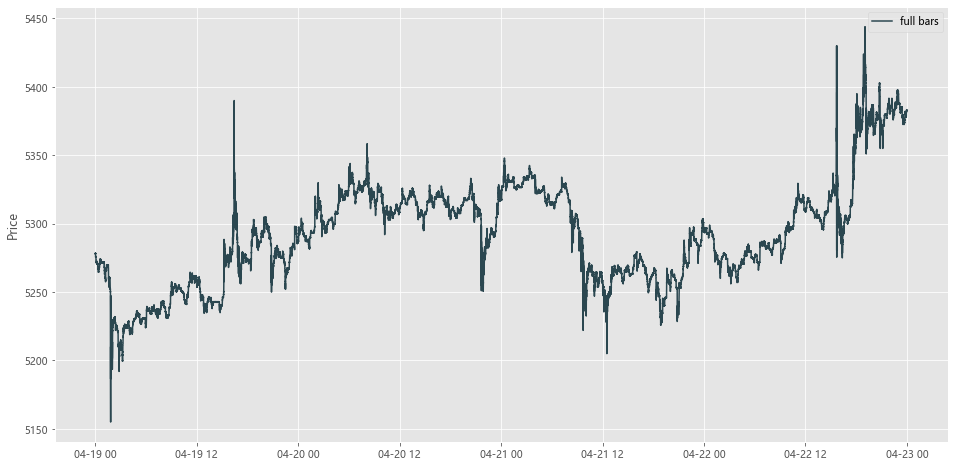

In [ ]:
plt.plot( data['timestamp'], data['price'], color=dt_hex, label='full bars' )
plt.legend( loc=0, frameon=True )
plt.ylabel('Price')
plt.show()

在量化中，我们很多时候并不需要每条 tick 的高频信息，我们需要的是从中进行有效的采样。

> 采样是指从目标总体 (population) 中抽取一部分个体作为样本 (sample)，也可以对抽取出来的部分个体进行一些操作 (比如取平均) 作为一个样本。采样的目的是通过观察样本的属性，依据所获得的数据对总体的数量特征得出具有可靠性的估计判断，从而达到对总体的认识。

下面四节分别介绍等**时**抽样、等**笔**抽样、等**量**抽样和等**额**抽样。

### <font color='#2b4750' face='微软雅黑'>2.2 等时采样之 Time Bar</font><a name='2.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

等时抽样是将 tick 数据转换为 time bars，在「固定段时间」中抽样得到 (比如固定每1, 15, 30, 60 分钟进行一次抽样)。

有了每个 time bar 里的一组 tick 数据，我们

- 可以找出 OHLC 四类价格 (K 线图)
- 也可以计算 (加权) 平均价格 (线状图)

我们先看看如果计算平均价格的。在一段固定的时间 $[T_s, T_e]$，计算

- 时间加权平均价 (Time-weighted Average Price, TWAP)
- 成交量加权平均价 (Volume-weighted Average Price, VWAP)

来当做在 $[T_s, T_e]$ 这段时间的一个样本。

假设在 $[T_s, T_e]$ 中有 n 个数据，其中 $T_s \leq t_1 < t_2 < ⋯ < t_n \leq T_e$。TWAP 实际上是 n 个价格的简单算术平均

<br>
<font color='blue'>
\begin{equation}
\text{TWAP}(T_s,T_e) = \frac{1}{n}\sum_{i=1}^n\text{Price}(t_i)
\end{equation}
</font>
    
VWAP 是 n 个价格的成交量加权平均

<br>
<font color='blue'>
\begin{equation}
\text{VWAP}(T_s,T_e) = \frac{\sum_{i=1}^n\text{Price}(t_i)\times\text{Volume}(t_i)}{\sum_{i=1}^n\text{Volume}(t_i)}
\end{equation}
</font>

如果所有成交量相同，VWAP 和 TWAP 等价。业界普遍用 VWAP。下图给出一个 TWAP 和 VWAP 极简例子。

<img src="TWAP VWAP.png" style="width:600px;height:120px;">

下面 Python 代码用来生成 VWAP，在 XBTUSD 数据中，成交量在 `homeNotional` 栏 (`weight_column`) 下，价格在 `price` 栏 (`avg_column`) 下。

In [ ]:
def vwap( group, avg_column, weight_column ):
    p = group[avg_column]
    v = group[weight_column]
    return (p*v).sum() / v.sum()

Time bars 的简单示意图如下：

<img src="Time Bar.png" style="width:600px;height:250px;">

上图 time bars 根据每 15 分钟抽样得到 3 个 bar，分别计算出 VWAP。接下来在 XBTUSD 的数据中设置分组间隔为 15 分钟

- 用 `set_index()` 函数将 `timestamp` 作为 index。
- 用 `groupby()` 函数将周期为 15min 的 `Grouper` 分组。

注意 pandas 里面的函数 `Grouper()` 里的 freq 也可以方便的改成其他周期参数。

In [ ]:
freq = '15min'
time_group = data.set_index('timestamp').groupby( pd.Grouper(freq=freq) )

按照 15min 在原数据上分组，那么每个组的大小之和应该和原数据的大小一样，果然是 1434823 条数据。

In [ ]:
print( np.sum(time_group.size()) )

1434823


让我们看看按**等时抽样**下的每个 time bar 里含有多少个 tick 数据。

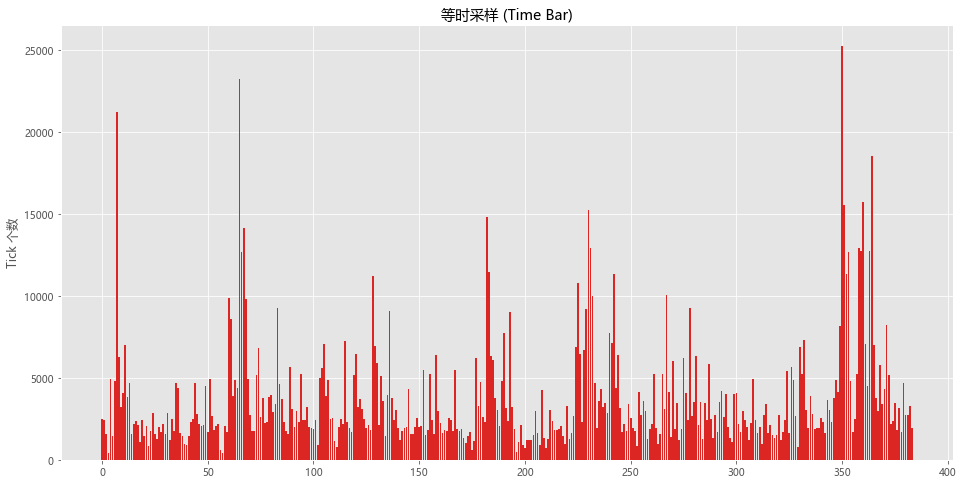

In [ ]:
plt.bar( np.arange(len(time_group)), time_group.size().values, color=r_hex )
plt.title('等时采样 (Time Bar)')
plt.ylabel('Tick 个数')
plt.show()

定义函数 `print_groups()` 打印分组的信息。

In [ ]:
def print_groups(groupobject):
    for name, group in groupobject:
        print( '\n', name )
        print( group.head(3).append(group.tail(3)) )

In [ ]:
print_groups(time_group)


 2019-04-19 00:00:00
                            symbol  side   size   price  tickDirection  \
timestamp                                                                
2019-04-19 00:00:08.318873  XBTUSD  Sell     10  5278.0      MinusTick   
2019-04-19 00:00:08.367122  XBTUSD  Sell  22959  5278.0  ZeroMinusTick   
2019-04-19 00:00:08.449684  XBTUSD   Buy    510  5278.5       PlusTick   
2019-04-19 00:14:49.828100  XBTUSD   Buy      1  5272.0       PlusTick   
2019-04-19 00:14:53.328525  XBTUSD  Sell  10000  5271.5      MinusTick   
2019-04-19 00:14:57.042298  XBTUSD  Sell     10  5271.5  ZeroMinusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-19 00:00:08.318873  f62c0ad2-c165-3446-a99e-d081c2e6ea65      189470   
2019-04-19 00:00:08.367122  46a184e2-ef8c-aa5e-fb90-81f325174fa5   435004173   
2019-04-19 00:00:08.449684  ac2befd6-ccc8-9fac-be93-75b686565d07 

2019-04-19 02:59:59.806288      1.148127           5987.0  

 2019-04-19 03:00:00
                            symbol side  size   price tickDirection  \
timestamp                                                             
2019-04-19 03:00:05.750877  XBTUSD  Buy  2653  5214.5  ZeroPlusTick   
2019-04-19 03:00:05.750877  XBTUSD  Buy    28  5214.5  ZeroPlusTick   
2019-04-19 03:00:05.750877  XBTUSD  Buy   250  5214.5  ZeroPlusTick   
2019-04-19 03:14:59.232476  XBTUSD  Buy  5000  5206.5  ZeroPlusTick   
2019-04-19 03:14:59.778580  XBTUSD  Buy    23  5206.5  ZeroPlusTick   
2019-04-19 03:14:59.778580  XBTUSD  Buy    77  5206.5  ZeroPlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-19 03:00:05.750877  61b2ded2-d55a-64e0-8ed1-f7bf5269e32a    50876581   
2019-04-19 03:00:05.750877  2e8f65b3-4d6f-9e7c-63fd-0062815f4c78      536956   
2019-04-19 03:00:05.750877  e

2019-04-19 08:44:59.239252      0.019089            100.0  

 2019-04-19 08:45:00
                            symbol side   size   price tickDirection  \
timestamp                                                              
2019-04-19 08:45:02.200676  XBTUSD  Buy     15  5239.0      PlusTick   
2019-04-19 08:45:02.830027  XBTUSD  Buy    185  5239.0  ZeroPlusTick   
2019-04-19 08:45:02.830027  XBTUSD  Buy    500  5239.0  ZeroPlusTick   
2019-04-19 08:59:59.145402  XBTUSD  Buy  91742  5254.5      PlusTick   
2019-04-19 08:59:59.203628  XBTUSD  Buy   5000  5254.5  ZeroPlusTick   
2019-04-19 08:59:59.957405  XBTUSD  Buy  60000  5254.5  ZeroPlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-19 08:45:02.200676  3e64bfad-2788-501a-b851-d32ce5fe6321      286320   
2019-04-19 08:45:02.830027  ed522531-21c3-1b5d-1617-cc7b787031bb     3531280   
2019-04-19 08:45:02.8

                            symbol  side  size   price tickDirection  \
timestamp                                                              
2019-04-19 14:15:00.622743  XBTUSD   Buy     1  5243.0  ZeroPlusTick   
2019-04-19 14:15:00.885246  XBTUSD  Sell   100  5242.5     MinusTick   
2019-04-19 14:15:02.217108  XBTUSD   Buy   305  5243.0      PlusTick   
2019-04-19 14:29:59.553190  XBTUSD   Buy   200  5243.0  ZeroPlusTick   
2019-04-19 14:29:59.553190  XBTUSD   Buy  1000  5243.0  ZeroPlusTick   
2019-04-19 14:29:59.553190  XBTUSD   Buy  5923  5243.0  ZeroPlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-19 14:15:00.622743  f56fa764-4c2d-cf72-800e-aebf719421bf       19073   
2019-04-19 14:15:00.885246  194e1bd1-d56d-9073-03a6-05dc1ad13d4f     1907500   
2019-04-19 14:15:02.217108  90d46c71-68dd-ca88-e1da-d5fa1f2986fe     5817265   
2019-04-19 14:29:59.553

2019-04-19 19:44:59.957149      0.000189              1.0  

 2019-04-19 19:45:00
                            symbol  side   size   price  tickDirection  \
timestamp                                                                
2019-04-19 19:45:00.788627  XBTUSD   Buy      1  5295.0       PlusTick   
2019-04-19 19:45:01.744598  XBTUSD   Buy      5  5295.0   ZeroPlusTick   
2019-04-19 19:45:01.901626  XBTUSD   Buy     31  5295.0   ZeroPlusTick   
2019-04-19 19:59:59.385786  XBTUSD  Sell    285  5294.5  ZeroMinusTick   
2019-04-19 19:59:59.918546  XBTUSD   Buy  10000  5295.0       PlusTick   
2019-04-19 19:59:59.943926  XBTUSD   Buy      3  5295.0   ZeroPlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-19 19:45:00.788627  2ce5c656-3dc9-f170-01d0-cc13957d621e       18886   
2019-04-19 19:45:01.744598  0bea6a49-dd62-113c-5893-635ca7367db6       94430   
2019-

2019-04-20 00:44:55.269326      0.018902            100.0  

 2019-04-20 00:45:00
                            symbol  side  size   price  tickDirection  \
timestamp                                                               
2019-04-20 00:45:01.411646  XBTUSD  Sell    21  5290.5  ZeroMinusTick   
2019-04-20 00:45:07.574718  XBTUSD   Buy  1000  5291.0       PlusTick   
2019-04-20 00:45:13.328616  XBTUSD  Sell    50  5290.5      MinusTick   
2019-04-20 00:59:59.016616  XBTUSD  Sell    15  5287.0  ZeroMinusTick   
2019-04-20 00:59:59.016616  XBTUSD  Sell     3  5287.0  ZeroMinusTick   
2019-04-20 00:59:59.016616  XBTUSD  Sell  6818  5287.0  ZeroMinusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-20 00:45:01.411646  abcffa35-96b1-45e1-e9bb-bf53969f6a48      396942   
2019-04-20 00:45:07.574718  1d95a897-99c8-d2e7-c4ae-ae8a586c2344    18900000   
2019-04-20 00


 2019-04-20 06:15:00
                            symbol  side  size   price  tickDirection  \
timestamp                                                               
2019-04-20 06:15:00.887238  XBTUSD  Sell    20  5331.5      MinusTick   
2019-04-20 06:15:03.831005  XBTUSD  Sell    50  5331.5  ZeroMinusTick   
2019-04-20 06:15:05.323620  XBTUSD  Sell  1000  5331.5  ZeroMinusTick   
2019-04-20 06:29:59.090015  XBTUSD  Sell   300  5329.5  ZeroMinusTick   
2019-04-20 06:29:59.090015  XBTUSD  Sell  2099  5329.5  ZeroMinusTick   
2019-04-20 06:29:59.335537  XBTUSD  Sell   200  5329.5  ZeroMinusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-20 06:15:00.887238  dab78ce1-be53-cf5c-df51-2200b0a64d62      375120   
2019-04-20 06:15:03.831005  98a908d6-6faf-ecd2-445b-88bb6f4dc3e1      937800   
2019-04-20 06:15:05.323620  7a3ad44b-0db5-545c-1f32-3a496a55dfdc    18756

2019-04-20 10:14:59.949788      4.574250          24246.0  

 2019-04-20 10:15:00
                            symbol  side  size   price tickDirection  \
timestamp                                                              
2019-04-20 10:15:00.797064  XBTUSD  Sell   100  5300.0     MinusTick   
2019-04-20 10:15:00.878457  XBTUSD   Buy  1000  5300.5      PlusTick   
2019-04-20 10:15:01.634957  XBTUSD   Buy   400  5300.5  ZeroPlusTick   
2019-04-20 10:29:53.822630  XBTUSD   Buy  8000  5313.0  ZeroPlusTick   
2019-04-20 10:29:55.539189  XBTUSD   Buy   986  5313.0  ZeroPlusTick   
2019-04-20 10:29:59.592165  XBTUSD   Buy     5  5313.0  ZeroPlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-20 10:15:00.797064  3112ec86-d92e-6158-cffe-e51b8d47c872     1886800   
2019-04-20 10:15:00.878457  e777f653-7ee6-6def-4e9c-11b3ae6b0889    18866000   
2019-04-20 10:15:01.6

                            symbol  side   size   price  tickDirection  \
timestamp                                                                
2019-04-20 16:15:00.540602  XBTUSD  Sell    773  5318.0  ZeroMinusTick   
2019-04-20 16:15:00.540602  XBTUSD  Sell  12000  5318.0  ZeroMinusTick   
2019-04-20 16:15:00.540602  XBTUSD  Sell   7227  5318.0  ZeroMinusTick   
2019-04-20 16:29:55.441591  XBTUSD  Sell     10  5322.0      MinusTick   
2019-04-20 16:29:55.441591  XBTUSD  Sell   7990  5322.0  ZeroMinusTick   
2019-04-20 16:29:59.346378  XBTUSD   Buy    540  5322.5       PlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-20 16:15:00.540602  c127a71b-b244-ffbb-8b2e-309b4ea0bc10    14535492   
2019-04-20 16:15:00.540602  2879a7f4-87f8-ef51-76b5-0995223de95e   225648000   
2019-04-20 16:15:00.540602  7798a351-fa3f-6561-0084-7af09251fa78   135896508   
2019-04

                            symbol  side   size   price  tickDirection  \
timestamp                                                                
2019-04-20 22:15:00.618113  XBTUSD   Buy   1000  5287.0       PlusTick   
2019-04-20 22:15:01.718845  XBTUSD  Sell   2000  5286.5      MinusTick   
2019-04-20 22:15:02.299230  XBTUSD  Sell      5  5286.5  ZeroMinusTick   
2019-04-20 22:29:57.302599  XBTUSD   Buy  40000  5283.0   ZeroPlusTick   
2019-04-20 22:29:58.809573  XBTUSD   Buy  18607  5283.0   ZeroPlusTick   
2019-04-20 22:29:58.809573  XBTUSD   Buy   1393  5283.0   ZeroPlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-20 22:15:00.618113  0d2ac356-9ec0-fe98-ec70-1fd1a706048c    18914000   
2019-04-20 22:15:01.718845  fb684d6e-0e7b-3c1d-3565-d5fb5c40da2a    37832000   
2019-04-20 22:15:02.299230  0c9cb471-cf0f-2528-8cb5-51871708de26       94580   
2019-04

2019-04-21 04:14:59.079020      0.018785            100.0  

 2019-04-21 04:15:00
                            symbol  side  size   price tickDirection  \
timestamp                                                              
2019-04-21 04:15:00.786638  XBTUSD   Buy   100  5323.5  ZeroPlusTick   
2019-04-21 04:15:06.722421  XBTUSD   Buy  9047  5323.5  ZeroPlusTick   
2019-04-21 04:15:06.722421  XBTUSD   Buy    14  5323.5  ZeroPlusTick   
2019-04-21 04:29:46.761472  XBTUSD  Sell  5000  5323.0     MinusTick   
2019-04-21 04:29:53.533914  XBTUSD   Buy   100  5323.5      PlusTick   
2019-04-21 04:29:59.201469  XBTUSD  Sell  1000  5323.0     MinusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-21 04:15:00.786638  70b21637-207b-cb0f-026b-56c9711e2efd     1878500   
2019-04-21 04:15:06.722421  c850324b-7826-ea0a-b0eb-654490d195e3   169947895   
2019-04-21 04:15:06.7

2019-04-21 09:14:59.338980      0.189040           1000.0  

 2019-04-21 09:15:00
                            symbol  side  size   price  tickDirection  \
timestamp                                                               
2019-04-21 09:15:00.721686  XBTUSD  Sell  1844  5290.0  ZeroMinusTick   
2019-04-21 09:15:00.721686  XBTUSD  Sell  5000  5290.0  ZeroMinusTick   
2019-04-21 09:15:00.721686  XBTUSD  Sell   217  5290.0  ZeroMinusTick   
2019-04-21 09:29:59.390670  XBTUSD   Buy   250  5283.0   ZeroPlusTick   
2019-04-21 09:29:59.588879  XBTUSD  Sell   300  5282.5      MinusTick   
2019-04-21 09:29:59.673145  XBTUSD   Buy  1000  5283.0       PlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-21 09:15:00.721686  c2dc28c4-b42d-d957-e2bc-a8862ddf76ec    34858976   
2019-04-21 09:15:00.721686  f03f5ba8-4cd8-b6c2-4f71-9e9b183ea421    94520000   
2019-04-21 09

2019-04-21 15:44:57.423060      1.895200          10000.0  

 2019-04-21 15:45:00
                            symbol  side    size   price tickDirection  \
timestamp                                                                
2019-04-21 15:45:00.591255  XBTUSD   Buy    1000  5276.5  ZeroPlusTick   
2019-04-21 15:45:00.609964  XBTUSD  Sell    2000  5276.0     MinusTick   
2019-04-21 15:45:01.011167  XBTUSD   Buy      14  5276.5      PlusTick   
2019-04-21 15:59:59.847988  XBTUSD   Buy       2  5278.5  ZeroPlusTick   
2019-04-21 15:59:59.847988  XBTUSD   Buy    1000  5278.5  ZeroPlusTick   
2019-04-21 15:59:59.847988  XBTUSD   Buy  226667  5278.5  ZeroPlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-21 15:45:00.591255  9022a39c-845c-2925-be0a-2da6c9686b8d    18952000   
2019-04-21 15:45:00.609964  36093553-2bb2-fc41-f771-4cff1f58649b    37908000   
2019-

2019-04-21 22:14:59.845509      0.363928           1923.0  

 2019-04-21 22:15:00
                            symbol  side  size   price  tickDirection  \
timestamp                                                               
2019-04-21 22:15:00.748578  XBTUSD   Buy     5  5284.0   ZeroPlusTick   
2019-04-21 22:15:01.916942  XBTUSD   Buy  3072  5284.0   ZeroPlusTick   
2019-04-21 22:15:01.916942  XBTUSD   Buy   545  5284.0   ZeroPlusTick   
2019-04-21 22:29:56.789569  XBTUSD  Sell   500  5293.0  ZeroMinusTick   
2019-04-21 22:29:59.104625  XBTUSD  Sell  1500  5293.0  ZeroMinusTick   
2019-04-21 22:29:59.823976  XBTUSD   Buy    10  5293.5       PlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-21 22:15:00.748578  dc383c10-0e03-4bf1-fed7-eb3036f480c8       94625   
2019-04-21 22:15:01.916942  808733d5-f79c-a0aa-67bc-e4734c35c428    58137600   
2019-04-21 22

2019-04-22 04:14:57.264744      0.000190              1.0  

 2019-04-22 04:15:00
                            symbol  side  size   price  tickDirection  \
timestamp                                                               
2019-04-22 04:15:01.513463  XBTUSD  Sell   500  5267.5      MinusTick   
2019-04-22 04:15:06.492041  XBTUSD   Buy  5950  5268.0       PlusTick   
2019-04-22 04:15:21.905983  XBTUSD   Buy     1  5268.0   ZeroPlusTick   
2019-04-22 04:29:52.527814  XBTUSD  Sell   233  5273.0  ZeroMinusTick   
2019-04-22 04:29:52.527814  XBTUSD  Sell  1414  5273.0  ZeroMinusTick   
2019-04-22 04:29:52.874324  XBTUSD   Buy  2981  5273.5       PlusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-22 04:15:01.513463  b97062e2-f7e8-2683-2576-4aaa8c4955c2     9492000   
2019-04-22 04:15:06.492041  a38cf96c-d7c8-c33e-d0b3-74ab2948fbb5   112948850   
2019-04-22 04

2019-04-22 10:14:59.680135      1.596095           8453.0  

 2019-04-22 10:15:00
                            symbol  side  size   price tickDirection  \
timestamp                                                              
2019-04-22 10:15:01.442313  XBTUSD   Buy  1547  5296.0  ZeroPlusTick   
2019-04-22 10:15:01.442313  XBTUSD   Buy  3453  5296.0  ZeroPlusTick   
2019-04-22 10:15:02.442913  XBTUSD   Buy   650  5296.0  ZeroPlusTick   
2019-04-22 10:29:31.271981  XBTUSD   Buy     1  5296.5      PlusTick   
2019-04-22 10:29:36.557507  XBTUSD   Buy   250  5296.5  ZeroPlusTick   
2019-04-22 10:29:38.881710  XBTUSD  Sell     1  5296.0     MinusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-22 10:15:01.442313  d20fcf40-ea67-6035-7879-ef080ae22338    29210454   
2019-04-22 10:15:01.442313  7c8065bb-d54c-17cc-da63-240f3ae5e5e8    65199546   
2019-04-22 10:15:02.4

2019-04-22 15:59:59.580251      5.045084          26780.0  

 2019-04-22 16:00:00
                            symbol  side  size   price  tickDirection  \
timestamp                                                               
2019-04-22 16:00:04.868532  XBTUSD  Sell  1050  5308.0  ZeroMinusTick   
2019-04-22 16:00:04.934535  XBTUSD   Buy     1  5308.5       PlusTick   
2019-04-22 16:00:05.480667  XBTUSD  Sell    58  5308.0      MinusTick   
2019-04-22 16:14:59.557676  XBTUSD   Buy  1111  5294.5   ZeroPlusTick   
2019-04-22 16:14:59.877645  XBTUSD   Buy   500  5294.5   ZeroPlusTick   
2019-04-22 16:14:59.908144  XBTUSD  Sell  4000  5294.0      MinusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-22 16:00:04.868532  d8178091-a29a-f1b0-2ca5-ec7438d09c18    19780950   
2019-04-22 16:00:04.934535  407635a1-f78b-db49-aa67-c3d59107a486       18838   
2019-04-22 16

2019-04-22 21:59:57.212855      0.005947             32.0  

 2019-04-22 22:00:00
                            symbol  side  size   price  tickDirection  \
timestamp                                                               
2019-04-22 22:00:06.157528  XBTUSD  Sell    28  5380.5      MinusTick   
2019-04-22 22:00:06.187054  XBTUSD  Sell   260  5380.5  ZeroMinusTick   
2019-04-22 22:00:06.187054  XBTUSD  Sell    34  5380.5  ZeroMinusTick   
2019-04-22 22:14:59.633517  XBTUSD  Sell    26  5390.5  ZeroMinusTick   
2019-04-22 22:14:59.633517  XBTUSD  Sell  2500  5390.5  ZeroMinusTick   
2019-04-22 22:14:59.633517  XBTUSD  Sell    24  5390.5  ZeroMinusTick   

                                                      trdMatchID  grossValue  \
timestamp                                                                      
2019-04-22 22:00:06.157528  796ccdb6-8340-c587-bb18-ebe628eef932      520408   
2019-04-22 22:00:06.187054  207c7c31-d491-4e76-57ac-e8813dcde40a     4832360   
2019-04-22 22

In [ ]:
data_time_vwap = time_group.apply(vwap, 'price', 'homeNotional')
data_time_vwap.head(3).append(data_time_vwap.tail(3))

timestamp
2019-04-19 00:00:00    5273.959209
2019-04-19 00:15:00    5267.132478
2019-04-19 00:30:00    5272.381528
2019-04-22 23:15:00    5381.682246
2019-04-22 23:30:00    5375.074330
2019-04-22 23:45:00    5379.497270
dtype: float64

In [ ]:
t_time = data_time_vwap.index
vwap_time = data_time_vwap.values

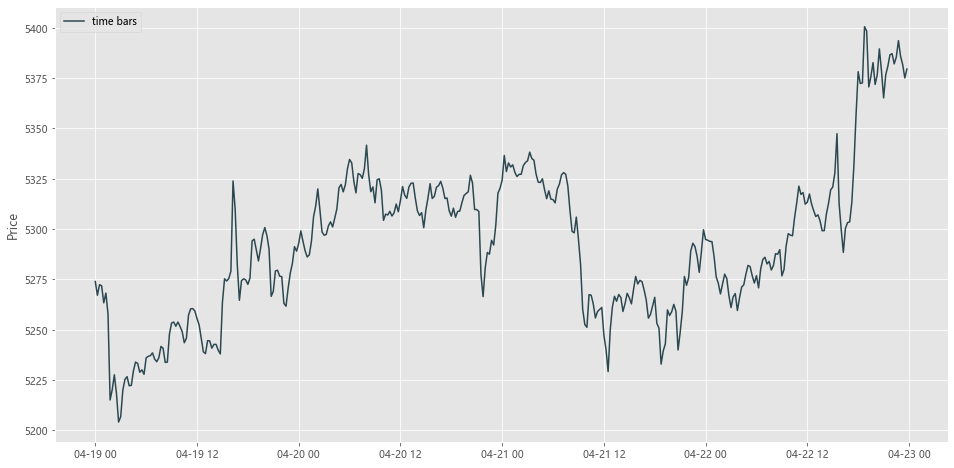

In [ ]:
plt.plot( t_time, vwap_time, color=dt_hex, label='time bars' )
plt.legend( loc=0, frameon=True )
plt.ylabel('Price')
plt.show()

Time bars 是最普遍的，但是它有两个缺点：

1. 信息从来都不会均速在市场流动，比如股市开盘交易比临近中午交易要活跃的多。

2. 等时采样得到的序列通常呈现自相关 (serial correlation)，异方差 (heteroscedasticity) 和收益非正态 (non-normal return) 等不好的性质。

如何改进？用**等笔采样**方法

### <font color='#2b4750' face='微软雅黑'>2.3 等笔采样之 Tick Bar</font><a name='2.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

等笔采样是将 tick 数据转换为 tick bars，以每段时间含「固定笔数」的前提下中采样得到 (比如固定每 1000, 2000, 3000 笔进行一次抽样)。

这个固定的笔数如何确定呢？通常来说我们对每长时间抽样一次有个概念(如每 15 分钟)，然后得到 bar 的个数 (3 个)。同样，在等笔采样下，我们也希望大概得到 3 个bar (即每个 bar 里含 2 个 tick)。

    每个 bar 含 tick 数 = tick 总数 / bar 数

Tick bars 的简单示意图如下：

<img src="Tick Bar.png" style="width:600px;height:220px;">

下面代码第 1 行计算 bar 的数量 384，第 2 行计算 tick 的总数量 1434823，第 3-4 行计算每条 bar 中 tick 的数量并弄成整百 3700 (例如：3714 就转化成 3700)。

In [ ]:
num_time_bars = len(time_group)
total_ticks = len(data)
num_ticks_per_bar = total_ticks / num_time_bars
num_ticks_per_bar = int(round( num_ticks_per_bar, -2))

print( '所有数据的个数 (总笔数) 为', total_ticks )
print( '等比采样下 Bar 的个数为', num_time_bars )
print( '每个 Bar 含有的笔数为', num_ticks_per_bar )

所有数据的个数 (总笔数) 为 1434823
等比采样下 Bar 的个数为 384
每个 Bar 含有的笔数为 3700


接下来的代码将 ticks 分组。第 1-2 行用运算符 `//` 对 `df.index` 进行取整，[0, 1, 2, 3, 4, 5] // 3 就等于 [0, 0, 0, 1, 1, 1]。取整的数被巧妙的当成 `groupID` 用来分组。

从下面的结果来看，在 GroupID 等于 0 的那组里，tick 的 ID 从 0 到 3699，就是 3700 个。

In [ ]:
tick_group = data.assign( groupID=lambda df: np.arange(len(df)) // num_ticks_per_bar ) \
                 .groupby('groupID')
print_groups( tick_group )


 0
                      timestamp  symbol  side   size   price  tickDirection  \
0    2019-04-19 00:00:08.318873  XBTUSD  Sell     10  5278.0      MinusTick   
1    2019-04-19 00:00:08.367122  XBTUSD  Sell  22959  5278.0  ZeroMinusTick   
2    2019-04-19 00:00:08.449684  XBTUSD   Buy    510  5278.5       PlusTick   
3697 2019-04-19 00:21:26.611232  XBTUSD  Sell    200  5266.0  ZeroMinusTick   
3698 2019-04-19 00:21:26.611232  XBTUSD  Sell   3000  5266.0  ZeroMinusTick   
3699 2019-04-19 00:21:26.611232  XBTUSD  Sell     42  5266.0  ZeroMinusTick   

                                trdMatchID  grossValue  homeNotional  \
0     f62c0ad2-c165-3446-a99e-d081c2e6ea65      189470      0.001895   
1     46a184e2-ef8c-aa5e-fb90-81f325174fa5   435004173      4.350042   
2     ac2befd6-ccc8-9fac-be93-75b686565d07     9661950      0.096620   
3697  1b291040-7358-0c8c-3a21-0f556b5627a2     3798000      0.037980   
3698  904cfaa1-bc64-026b-c7f7-315fdaf376d7    56970000      0.569700   
3699  2d14

59199           3000.0       15  

 16
                       timestamp  symbol  side  size   price  tickDirection  \
59200 2019-04-19 02:56:02.093394  XBTUSD  Sell   200  5212.5  ZeroMinusTick   
59201 2019-04-19 02:56:02.286628  XBTUSD  Sell  3800  5212.5  ZeroMinusTick   
59202 2019-04-19 02:56:02.848777  XBTUSD   Buy  1000  5213.0       PlusTick   
62897 2019-04-19 03:12:54.402338  XBTUSD  Sell   820  5199.5  ZeroMinusTick   
62898 2019-04-19 03:12:54.402338  XBTUSD  Sell   900  5199.5  ZeroMinusTick   
62899 2019-04-19 03:12:54.402338  XBTUSD  Sell  1000  5199.5  ZeroMinusTick   

                                 trdMatchID  grossValue  homeNotional  \
59200  e992240a-c8c3-627a-d906-ea5796af03f4     3837000      0.038370   
59201  ce70e811-5197-d65f-4b8e-e0b8ff22ef09    72903000      0.729030   
59202  93d50ee2-8417-63b9-e9ab-1f3945754b46    19183000      0.191830   
62897  21c87f16-4abe-fec8-17ea-de5c73a56f68    15771060      0.157711   
62898  3b66ea79-e141-e3db-6438-e0245809ea9

114699              2.0       30  

 31
                        timestamp  symbol  side   size   price  tickDirection  \
114700 2019-04-19 09:03:43.996402  XBTUSD  Sell    900  5252.0      MinusTick   
114701 2019-04-19 09:03:44.389791  XBTUSD  Sell   2500  5252.0  ZeroMinusTick   
114702 2019-04-19 09:03:44.406308  XBTUSD  Sell  34230  5252.0  ZeroMinusTick   
118397 2019-04-19 09:29:44.792490  XBTUSD  Sell  27194  5255.0  ZeroMinusTick   
118398 2019-04-19 09:29:45.039663  XBTUSD  Sell    100  5254.5      MinusTick   
118399 2019-04-19 09:29:45.127690  XBTUSD  Sell   5900  5254.5  ZeroMinusTick   

                                  trdMatchID  grossValue  homeNotional  \
114700  236b9f8c-1037-b797-6db2-62792f9fc73e    17136000      0.171360   
114701  6ab52efe-fadc-6570-f39b-cf78a16a4e3c    47600000      0.476000   
114702  db96a9ae-6e28-5a13-cfdf-71f2ca95430b   651739200      6.517392   
118397  814830a0-822d-a2c6-8ad8-cef29f738ae6   517474626      5.174746   
118398  ab97ed1f-2b5c-

170199            500.0       45  

 46
                        timestamp  symbol side  size   price tickDirection  \
170200 2019-04-19 15:12:39.221719  XBTUSD  Buy    33  5259.0  ZeroPlusTick   
170201 2019-04-19 15:12:39.221719  XBTUSD  Buy  3153  5259.0  ZeroPlusTick   
170202 2019-04-19 15:12:39.221719  XBTUSD  Buy  3154  5259.0  ZeroPlusTick   
173897 2019-04-19 15:13:36.426360  XBTUSD  Buy   172  5280.0  ZeroPlusTick   
173898 2019-04-19 15:13:36.426360  XBTUSD  Buy   260  5280.0  ZeroPlusTick   
173899 2019-04-19 15:13:36.426360  XBTUSD  Buy   100  5280.0  ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
170200  556b42ac-dad2-a527-9a9d-d97309965eaa      627495      0.006275   
170201  1984e701-0547-da17-d8b3-7d690157b9a1    59954295      0.599543   
170202  b5a762a0-75fe-6c43-9fb0-c5c193f1d56f    59973310      0.599733   
173897  20db4939-526f-24c3-cf71-146a43494830     3257508      0.032575   
173898  32565f89-bfaf-33e3-5c3d-682d0585d29

240499           9338.0       64  

 65
                        timestamp  symbol  side  size   price  tickDirection  \
240500 2019-04-19 16:51:43.872575  XBTUSD  Sell  1562  5278.0  ZeroMinusTick   
240501 2019-04-19 16:51:43.904118  XBTUSD  Sell  5328  5278.0  ZeroMinusTick   
240502 2019-04-19 16:51:43.904118  XBTUSD  Sell    68  5278.0  ZeroMinusTick   
244197 2019-04-19 16:56:09.966553  XBTUSD  Sell   448  5269.5  ZeroMinusTick   
244198 2019-04-19 16:56:09.966553  XBTUSD  Sell    45  5269.5  ZeroMinusTick   
244199 2019-04-19 16:56:09.966553  XBTUSD  Sell    51  5269.5  ZeroMinusTick   

                                  trdMatchID  grossValue  homeNotional  \
240500  da3a0ccd-631e-08f4-1aa1-f20a787ceb26    29595214      0.295952   
240501  182316c4-83c2-e328-93a4-b8e35cd588fd   100949616      1.009496   
240502  f3013cfd-8a48-a02c-a967-7adcbcae3627     1288396      0.012884   
244197  f9860688-2c72-5eb1-d2da-49ecfbecfe5d     8501696      0.085017   
244198  89ec78f2-e6a1-3d28-d7

321899     37.914000         200000.0       86  

 87
                        timestamp  symbol  side   size   price  tickDirection  \
321900 2019-04-19 21:21:57.852488  XBTUSD  Sell     66  5275.0  ZeroMinusTick   
321901 2019-04-19 21:21:57.852488  XBTUSD  Sell   3000  5275.0  ZeroMinusTick   
321902 2019-04-19 21:21:57.852488  XBTUSD  Sell  10000  5275.0  ZeroMinusTick   
325597 2019-04-19 21:41:13.796996  XBTUSD   Buy    146  5278.0   ZeroPlusTick   
325598 2019-04-19 21:41:13.796996  XBTUSD   Buy     40  5278.0   ZeroPlusTick   
325599 2019-04-19 21:41:13.796996  XBTUSD   Buy    100  5278.0   ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
321900  e72c52cd-a665-52c6-3534-74eb7bea7342     1251162      0.012512   
321901  c6f6fd75-4682-41da-a71d-3757f811ad30    56871000      0.568710   
321902  a5752878-7fe6-dde3-ffe1-6c09fe98d61d   189570000      1.895700   
325597  036caaf7-77be-8999-da2c-e69470d4f2c8     2766262      0.027663   
325598  

                        timestamp  symbol  side  size   price  tickDirection  \
399600 2019-04-20 03:31:29.191985  XBTUSD  Sell  2682  5300.0  ZeroMinusTick   
399601 2019-04-20 03:31:29.191985  XBTUSD  Sell  2000  5300.0  ZeroMinusTick   
399602 2019-04-20 03:31:29.191985  XBTUSD  Sell   156  5300.0  ZeroMinusTick   
403297 2019-04-20 04:12:13.461166  XBTUSD   Buy  5000  5300.0   ZeroPlusTick   
403298 2019-04-20 04:12:13.461166  XBTUSD   Buy  4500  5300.0   ZeroPlusTick   
403299 2019-04-20 04:12:13.461166  XBTUSD   Buy  1000  5300.0   ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
399600  bc201bf8-bee6-9e66-5d18-c382704ade8b    50603976      0.506040   
399601  b1e9d187-c181-9f93-7f92-d44853a53a72    37736000      0.377360   
399602  2c84dfa2-2883-e67d-cd10-365f16722bb4     2943408      0.029434   
403297  84d1758e-f0af-e692-8bd4-b2f0c29ddf2b    94340000      0.943400   
403298  00933ef6-541b-2df8-a0aa-5ca58119bb1e    84906000      0.84906

                        timestamp  symbol side   size   price tickDirection  \
481000 2019-04-20 09:09:12.707580  XBTUSD  Buy   2000  5306.5  ZeroPlusTick   
481001 2019-04-20 09:09:12.707580  XBTUSD  Buy  74478  5306.5  ZeroPlusTick   
481002 2019-04-20 09:09:13.301960  XBTUSD  Buy   5000  5306.5  ZeroPlusTick   
484697 2019-04-20 09:23:37.415284  XBTUSD  Buy      2  5327.0  ZeroPlusTick   
484698 2019-04-20 09:23:38.407383  XBTUSD  Buy      2  5327.0  ZeroPlusTick   
484699 2019-04-20 09:23:38.638458  XBTUSD  Buy     95  5327.0  ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
481000  e714aade-5cce-ad01-7daa-907dbdad0281    37690000      0.376900   
481001  e327a650-a8b8-dcbc-74af-ba63f7bed3f1  1403537910     14.035380   
481002  cab1cf67-21f3-527c-2431-315807763a02    94225000      0.942250   
484697  a321f838-1e5a-ff53-9d66-ba03d017ac56       37544      0.000375   
484698  e54b118c-6b90-e21a-4878-b5752a6e6726       37544      0.000375   
48

                        timestamp  symbol side  size   price tickDirection  \
555000 2019-04-20 15:31:53.992654  XBTUSD  Buy  1301  5328.0  ZeroPlusTick   
555001 2019-04-20 15:31:54.835760  XBTUSD  Buy  3000  5328.0  ZeroPlusTick   
555002 2019-04-20 15:31:55.115509  XBTUSD  Buy   424  5328.0  ZeroPlusTick   
558697 2019-04-20 15:43:16.048765  XBTUSD  Buy   302  5318.0  ZeroPlusTick   
558698 2019-04-20 15:43:16.048765  XBTUSD  Buy   500  5318.0  ZeroPlusTick   
558699 2019-04-20 15:43:16.048765  XBTUSD  Buy   199  5318.0  ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
555000  cec49071-34de-47cf-4dde-2e3417c3cbbb    24418469      0.244185   
555001  cdfdd436-cd85-52f1-c523-8f395030c893    56307000      0.563070   
555002  6ff75eaf-f6b0-b4cd-d5d4-c0012af1ca2b     7958056      0.079581   
558697  1981197b-ba64-d40f-9579-65033ad85b3d     5678808      0.056788   
558698  848f3d5c-a32c-a147-5bac-1125b2ca61ec     9402000      0.094020   
558699  f

                        timestamp  symbol  side   size   price  tickDirection  \
643800 2019-04-20 22:08:46.909872  XBTUSD   Buy     15  5277.5   ZeroPlusTick   
643801 2019-04-20 22:08:46.909872  XBTUSD   Buy   1000  5277.5   ZeroPlusTick   
643802 2019-04-20 22:08:46.909872  XBTUSD   Buy     17  5277.5   ZeroPlusTick   
647497 2019-04-20 22:17:51.638425  XBTUSD  Sell  22000  5286.0  ZeroMinusTick   
647498 2019-04-20 22:17:51.883383  XBTUSD  Sell   9000  5286.0  ZeroMinusTick   
647499 2019-04-20 22:17:52.691038  XBTUSD  Sell    700  5286.0  ZeroMinusTick   

                                  trdMatchID  grossValue  homeNotional  \
643800  06d30a91-08c9-3c47-753c-6d49c719e495      284220      0.002842   
643801  cb88efe3-8448-9441-d2e6-48a68aa186d8    18948000      0.189480   
643802  8576c28c-ee93-b655-ed6e-0dd7b1a0aeb4      322116      0.003221   
647497  2625fcac-902a-03ed-34b7-cf47f0839a69   416196000      4.161960   
647498  e7133bdf-7fa1-e42a-2737-71558b128bb3   170262000      

                        timestamp  symbol  side   size   price  tickDirection  \
725200 2019-04-21 05:52:28.573397  XBTUSD   Buy  13666  5314.0       PlusTick   
725201 2019-04-21 05:52:28.573397  XBTUSD   Buy     22  5314.0   ZeroPlusTick   
725202 2019-04-21 05:52:28.573397  XBTUSD   Buy     16  5314.0   ZeroPlusTick   
728897 2019-04-21 06:18:25.631279  XBTUSD  Sell   4000  5311.0  ZeroMinusTick   
728898 2019-04-21 06:18:25.631279  XBTUSD  Sell   4000  5311.0  ZeroMinusTick   
728899 2019-04-21 06:18:25.631279  XBTUSD  Sell   1000  5311.0  ZeroMinusTick   

                                  trdMatchID  grossValue  homeNotional  \
725200  41940d22-a14a-2680-0881-cb02ff968d9d   257166788      2.571668   
725201  200d68f0-7903-8773-6b2f-fcd964148769      413996      0.004140   
725202  46c456b3-797f-cd29-b821-3fda83fc6b0b      301088      0.003011   
728897  81fd6c7b-03a7-7acc-9048-a9c3df3aa9c3    75316000      0.753160   
728898  9e73b0be-8b65-8fa4-31dd-385a33a1ccdd    75316000      

                        timestamp  symbol  side  size   price  tickDirection  \
810300 2019-04-21 09:57:38.470218  XBTUSD   Buy  6000  5242.0   ZeroPlusTick   
810301 2019-04-21 09:57:38.470218  XBTUSD   Buy   300  5242.0   ZeroPlusTick   
810302 2019-04-21 09:57:38.470218  XBTUSD   Buy   417  5242.0   ZeroPlusTick   
813997 2019-04-21 10:03:10.117154  XBTUSD  Sell    14  5246.0  ZeroMinusTick   
813998 2019-04-21 10:03:10.117154  XBTUSD  Sell    42  5246.0  ZeroMinusTick   
813999 2019-04-21 10:03:10.117154  XBTUSD  Sell    33  5246.0  ZeroMinusTick   

                                  trdMatchID  grossValue  homeNotional  \
810300  0f6500d1-55d3-9133-5164-5f2c5bb90ec0   114462000      1.144620   
810301  fde9c5be-f87f-237b-c40d-f89c66082e27     5723100      0.057231   
810302  a8876a4a-ce56-943b-a299-aed97766f949     7955109      0.079551   
813997  86391954-fbac-5cb2-3cc0-2c1742aaa9a5      266868      0.002669   
813998  6c75630f-8368-0e5d-309b-6c13b4bbcaeb      800604      0.00800

891699             75.0      240  

 241
                        timestamp  symbol  side  size   price  tickDirection  \
891700 2019-04-21 14:13:55.046018  XBTUSD  Sell    75  5263.5  ZeroMinusTick   
891701 2019-04-21 14:13:55.046018  XBTUSD  Sell   781  5263.5  ZeroMinusTick   
891702 2019-04-21 14:13:55.046018  XBTUSD  Sell    44  5263.5  ZeroMinusTick   
895397 2019-04-21 14:31:27.582034  XBTUSD  Sell  1000  5258.5  ZeroMinusTick   
895398 2019-04-21 14:31:27.582034  XBTUSD  Sell    68  5258.5  ZeroMinusTick   
895399 2019-04-21 14:31:27.582034  XBTUSD  Sell    38  5258.5  ZeroMinusTick   

                                  trdMatchID  grossValue  homeNotional  \
891700  4247232f-1572-1951-2278-d86df5f557bb     1424925      0.014249   
891701  8efba504-edb3-5b21-274d-f2e09bf71276    14838219      0.148382   
891702  a0d7460c-0166-51ab-8961-25dbd40cd012      835956      0.008360   
895397  4514ab43-6675-fe3a-7199-5a388ef931de    19017000      0.190170   
895398  84fae2d1-caa5-08b3-e

976799            270.0      263  

 264
                        timestamp  symbol side  size   price tickDirection  \
976800 2019-04-21 21:02:28.039151  XBTUSD  Buy   270  5249.0  ZeroPlusTick   
976801 2019-04-21 21:02:28.039151  XBTUSD  Buy  1026  5249.0  ZeroPlusTick   
976802 2019-04-21 21:02:28.039151  XBTUSD  Buy  1356  5249.0  ZeroPlusTick   
980497 2019-04-21 21:20:34.716432  XBTUSD  Buy    25  5260.0  ZeroPlusTick   
980498 2019-04-21 21:20:34.716432  XBTUSD  Buy    15  5260.0  ZeroPlusTick   
980499 2019-04-21 21:20:34.716432  XBTUSD  Buy    15  5260.0  ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
976800  edddee76-d12b-000f-4414-176a49f9e57b     5143770      0.051438   
976801  60e2c5dc-7742-b0a2-5d8d-b93651ada7dd    19546326      0.195463   
976802  23765df8-8aac-2dab-92c7-8f1103793704    25833156      0.258332   
980497  a84fd447-5df0-1605-f0a0-8b9e042de139      475275      0.004753   
980498  7455b8a6-9d78-1e02-88b6-5a1ca05b1c

1054499             30.0      284  

 285
                         timestamp  symbol  side  size   price  tickDirection  \
1054500 2019-04-22 03:08:02.896353  XBTUSD  Sell  5473  5263.5  ZeroMinusTick   
1054501 2019-04-22 03:08:02.896353  XBTUSD  Sell  6000  5263.5  ZeroMinusTick   
1054502 2019-04-22 03:08:02.896353  XBTUSD  Sell    44  5263.5  ZeroMinusTick   
1058197 2019-04-22 03:19:28.253204  XBTUSD   Buy    50  5265.0   ZeroPlusTick   
1058198 2019-04-22 03:19:28.253204  XBTUSD   Buy    91  5265.0   ZeroPlusTick   
1058199 2019-04-22 03:19:28.253204  XBTUSD   Buy    91  5265.0   ZeroPlusTick   

                                   trdMatchID  grossValue  homeNotional  \
1054500  f1a209c0-62de-5602-6077-9ac114cb7b09   103981527      1.039815   
1054501  090fa980-9760-aada-517d-4d98d769ee42   113994000      1.139940   
1054502  9bff88a9-815f-892e-8464-d3857b9bcbad      835956      0.008360   
1058197  d0f4aa9f-9086-4742-3db0-307905e613da      949650      0.009496   
1058198  f76f27


 307
                         timestamp  symbol  side  size   price  tickDirection  \
1135900 2019-04-22 10:54:49.186791  XBTUSD   Buy    59  5309.5   ZeroPlusTick   
1135901 2019-04-22 10:54:49.186791  XBTUSD   Buy    14  5309.5   ZeroPlusTick   
1135902 2019-04-22 10:54:49.186791  XBTUSD   Buy    75  5309.5   ZeroPlusTick   
1139597 2019-04-22 11:00:15.324608  XBTUSD  Sell   430  5314.5      MinusTick   
1139598 2019-04-22 11:00:15.324608  XBTUSD  Sell    30  5314.5  ZeroMinusTick   
1139599 2019-04-22 11:00:15.324608  XBTUSD  Sell    40  5314.5  ZeroMinusTick   

                                   trdMatchID  grossValue  homeNotional  \
1135900  56104e73-a7b9-4341-acb2-86b5bd10c6f8     1111206      0.011112   
1135901  231a9bcf-89c1-e8e2-fdf7-440637e2e451      263676      0.002637   
1135902  4cff0dda-e1cd-86ed-6e22-f646ec0ee300     1412550      0.014125   
1139597  0af8c732-407b-5c0b-2048-6185da6b314b     8090880      0.080909   
1139598  ef6356b2-4fb2-b0af-226e-c97399e78cf0      

1217299            245.0      328  

 329
                         timestamp  symbol  side  size   price  tickDirection  \
1217300 2019-04-22 15:41:22.860684  XBTUSD  Sell   118  5310.0      MinusTick   
1217301 2019-04-22 15:41:22.860684  XBTUSD  Sell   100  5310.0  ZeroMinusTick   
1217302 2019-04-22 15:41:22.860684  XBTUSD  Sell   200  5310.0  ZeroMinusTick   
1220997 2019-04-22 15:42:07.945142  XBTUSD   Buy  3700  5362.5   ZeroPlusTick   
1220998 2019-04-22 15:42:07.998382  XBTUSD   Buy  1500  5362.5   ZeroPlusTick   
1220999 2019-04-22 15:42:08.137112  XBTUSD   Buy  1100  5362.5   ZeroPlusTick   

                                   trdMatchID  grossValue  homeNotional  \
1217300  9c96df31-0ada-8c5c-7d08-8ed1f3107207     2222176      0.022222   
1217301  45c0f8a3-37f8-ebc4-fecf-e1508cb75e2b     1883200      0.018832   
1217302  e0dc2ed7-6978-543a-7a93-d6a53293ad85     3766400      0.037664   
1220997  01005948-706f-77ce-0073-9ec79b0e4534    68997600      0.689976   
1220998  4709d5

                         timestamp  symbol side   size   price tickDirection  \
1298700 2019-04-22 17:49:44.526327  XBTUSD  Buy      1  5355.0  ZeroPlusTick   
1298701 2019-04-22 17:49:44.526327  XBTUSD  Buy   5000  5355.0  ZeroPlusTick   
1298702 2019-04-22 17:49:44.526327  XBTUSD  Buy   2948  5355.0  ZeroPlusTick   
1302397 2019-04-22 17:54:45.336426  XBTUSD  Buy  14923  5355.0  ZeroPlusTick   
1302398 2019-04-22 17:54:45.336426  XBTUSD  Buy  11756  5355.0  ZeroPlusTick   
1302399 2019-04-22 17:54:45.336426  XBTUSD  Buy   8000  5355.0  ZeroPlusTick   

                                   trdMatchID  grossValue  homeNotional  \
1298700  2bde9d4c-ea5e-9541-25e2-55e1a1e3db60       18674      0.000187   
1298701  6c66ef68-45c8-aab0-b18f-eb5051840bc4    93370000      0.933700   
1298702  c7a628c6-87ac-fe34-fe01-f60bc342cb65    55050952      0.550509   
1302397  04ff4159-f500-aa8f-9b90-13bfb392d55f   278672102      2.786721   
1302398  a7f1268a-7a56-a53f-7fa4-9b3870397a8b   219531544      2

                         timestamp  symbol  side   size   price  \
1376400 2019-04-22 19:50:38.659019  XBTUSD   Buy  28180  5383.5   
1376401 2019-04-22 19:50:38.659019  XBTUSD   Buy   3000  5383.5   
1376402 2019-04-22 19:50:38.659019  XBTUSD   Buy    300  5383.5   
1380097 2019-04-22 20:02:27.080561  XBTUSD  Sell    150  5367.0   
1380098 2019-04-22 20:02:27.080561  XBTUSD  Sell     75  5367.0   
1380099 2019-04-22 20:02:27.080561  XBTUSD  Sell    180  5367.0   

         tickDirection                            trdMatchID  grossValue  \
1376400   ZeroPlusTick  67265453-6a2c-8a8f-ace7-9baef2798b1e   523443500   
1376401   ZeroPlusTick  41878219-ce2b-8da7-8629-3817e8a97c64    55725000   
1376402   ZeroPlusTick  e793f503-da90-2ca8-bf08-47bc791dfc87     5572500   
1380097  ZeroMinusTick  feb84f3b-0155-56e3-1f09-babf096b87c3     2794800   
1380098  ZeroMinusTick  51eb868e-b5cc-4243-31b7-780689dd294d     1397400   
1380099  ZeroMinusTick  20e377b9-d8f6-552d-e171-7cd01c606e5c     3353760  

来看看按等笔采样下每个 bar 里含有多少笔数据。发现全部都是 3700 个，除了最后一个，因为不会那么巧 tick 总数能被 bar 数整除。

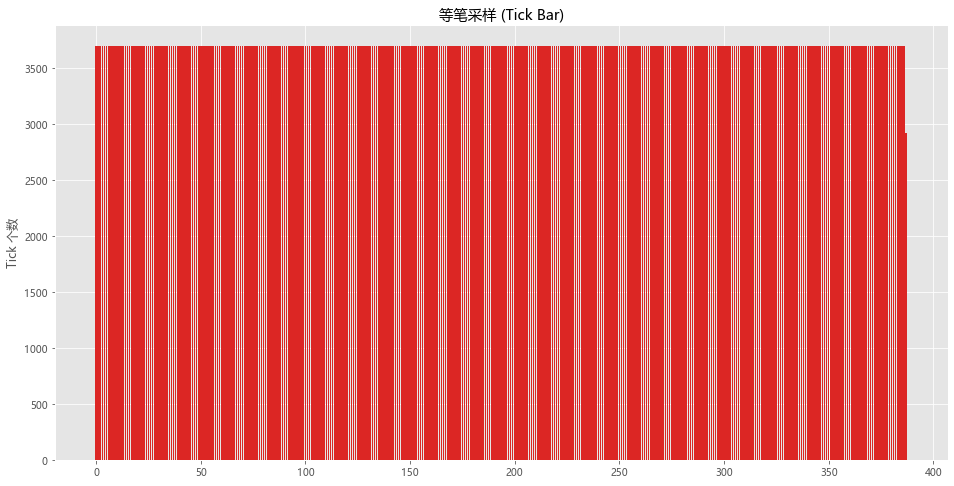

In [ ]:
plt.bar( np.arange(len(tick_group)), tick_group.size().values, color=r_hex )
plt.title('等笔采样 (Tick Bar)')
plt.ylabel('Tick 个数')
plt.show()

In [ ]:
print( np.sum(tick_group.size()) )

1434823


In [ ]:
data_tick_vwap = tick_group.apply(vwap, 'price', 'homeNotional')
data_tick_vwap.head(3).append(data_tick_vwap.tail(3))

groupID
0      5272.594382
1      5270.510707
2      5262.138186
385    5384.656864
386    5376.852452
387    5377.549229
dtype: float64

此时我们需要每个 tick bar 对应的时间戳。简单，用每个组的数据个数累加起来得到 `idx`，作为行标签从 `data['timestap]` 获取相对应时间戳，画出 tick bar 的线状图。

In [ ]:
idx = np.cumsum( tick_group.size() ) - 1
t_tick = data['timestamp'][idx].values
vwap_tick = data_tick_vwap.values

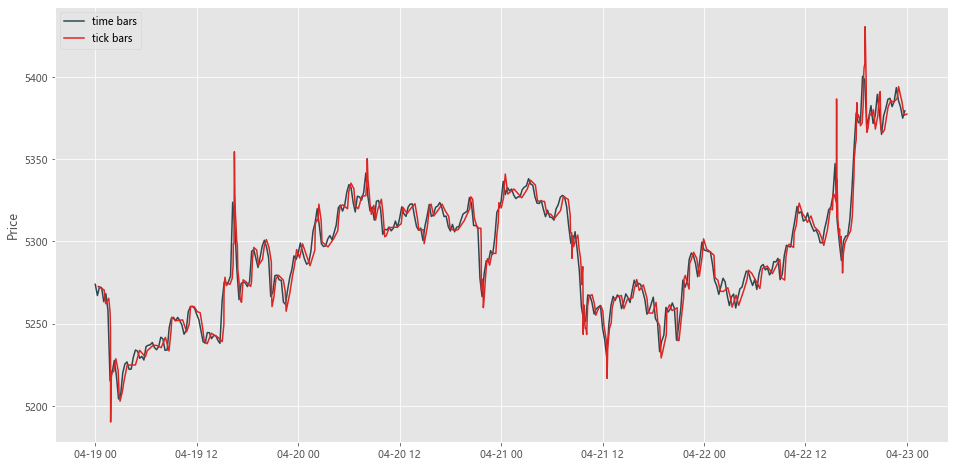

In [ ]:
plt.plot( t_time, vwap_time, color=dt_hex, label='time bars' )
plt.plot( t_tick, vwap_tick, color=r_hex, label='tick bars' )
plt.legend( loc=0, frameon=True )
plt.ylabel('Price')
plt.show()

等笔采样的优点：

    一些研究发现按 tick bar 来取样得到的数据更接近独立正态同分布 (IID)，而 IID 在统计上的均值和方差都有非常好的性质。

等笔采样的缺点：

    不过 tick bar 也有自身的问题，假设你下单要买 1000 股阿里巴巴，一次性的话就记录成 1 个 tick，但是分 10 单每单 100 股来买的话，就记录成 10 个 tick。这样明显不太合理。

如何改进？用**等量采样**方法。

### <font color='#2b4750' face='微软雅黑'>2.4 等量采样之 Volume Bar</font><a name='2.4'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

等量采样是将 tick 数据转换为 volume bars，以每段时间含**固定成交量**的前提下中采样得到 (比如固定每 1000 股阿里巴巴，每 200 手玉米期货进行一次抽样)。

这个固定的成交量如何确定呢？和等笔采样中的方法一样，先得到 bar 的个数 (3 个)。在等量采样下，我们计算累积成交量再除以 bar 的个数。

    每个 bar 含的成交量 = 总成交量 / bar 数

Volume bars 的简单示意图如下：

<img src="Volume Bar.PNG" style="width:600px;height:220px;">

上图好像和 tick bars 的一样，但后面的逻辑不一样。采样 volume bar 的方法是：

1. 计算总成交量是 1050

2. 计算每个 bar 的成交量是 350 = 1050/3 

3. 用 350 作为标准来组成 bar，很明显第 1-2 个 tick 组成 bar 1，第 3-4 个 tick 组成 bar 2，第 5-6 个 tick 组成 bar 3

首先用 `cumsum()` 函数计算累积成交量 `'homeNotional'`，用 `assign()` 函数并储存在 DataFrame 的 `'cumVolume'` 栏下。

In [ ]:
data_cum_volume = data.assign( cumVolume=data['homeNotional'].cumsum() )
data_cum_volume.head(3).append(data_cum_volume.tail(3))

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,cumVolume
0,2019-04-19 00:00:08.318873,XBTUSD,Sell,10,5278.0,MinusTick,f62c0ad2-c165-3446-a99e-d081c2e6ea65,189470,0.001895,10.0,1.894700e-03
1,2019-04-19 00:00:08.367122,XBTUSD,Sell,22959,5278.0,ZeroMinusTick,46a184e2-ef8c-aa5e-fb90-81f325174fa5,435004173,4.350042,22959.0,4.351937e+00
2,2019-04-19 00:00:08.449684,XBTUSD,Buy,510,5278.5,PlusTick,ac2befd6-ccc8-9fac-be93-75b686565d07,9661950,0.096620,510.0,4.448556e+00
1434820,2019-04-22 23:59:54.831787,XBTUSD,Sell,14690,5382.5,ZeroMinusTick,7139ea9f-fb14-ee82-3740-d3edf3206685,272925510,2.729255,14690.0,1.028160e+06
1434821,2019-04-22 23:59:59.321668,XBTUSD,Buy,3514,5383.0,PlusTick,f9e494c7-d5ac-453e-737f-e2ca6875d279,65279578,0.652796,3514.0,1.028161e+06
1434822,2019-04-22 23:59:59.321668,XBTUSD,Buy,6486,5383.0,ZeroPlusTick,81439489-8f7e-6cf2-3ab9-e77be2e07f4a,120490422,1.204904,6486.0,1.028162e+06


来看看按等量采样下每个 bar 里含多少成交量。第 1 行计算总成交量 1028161.8，第 2-3 行计算每条 bar 含的成交量并弄成整百 2700 (例如：2714 就转化成 2700)。

In [ ]:
total_volume = data_cum_volume.cumVolume.values[-1]
volume_per_bar = total_volume / num_time_bars
volume_per_bar  = int(round( volume_per_bar, -2))

print( '所有数据的总成交量为', total_volume )
print( '等量采样下 Bar 的个数为', num_time_bars )
print( '每个 Bar 含有的成交量为', volume_per_bar )

所有数据的总成交量为 1028161.8162190766
等量采样下 Bar 的个数为 384
每个 Bar 含有的成交量为 2700


接下来的代码按量 (volume) 来分组。第 1-2 行用运算符 `//` 对 `df.cumVolume` 进行取整，[0, 1000, 2000, 3000, 4000, 5000] // 2700 就等于 [0, 0, 0, 1, 1, 1]。取整的数被巧妙的当成 `groupID` 用来分组。

从下面的结果来看，在 GroupID 等于 0 的那组里，cumVolume 最后的值是 2698.11，非常接近 2700。

In [ ]:
volume_group = data_cum_volume.assign( groupID=lambda df: df.cumVolume // volume_per_bar ) \
                              .groupby('groupID')
print_groups( volume_group )


 0.0
                      timestamp  symbol  side   size   price  tickDirection  \
0    2019-04-19 00:00:08.318873  XBTUSD  Sell     10  5278.0      MinusTick   
1    2019-04-19 00:00:08.367122  XBTUSD  Sell  22959  5278.0  ZeroMinusTick   
2    2019-04-19 00:00:08.449684  XBTUSD   Buy    510  5278.5       PlusTick   
4387 2019-04-19 00:24:32.880768  XBTUSD   Buy     14  5265.0   ZeroPlusTick   
4388 2019-04-19 00:24:32.880768  XBTUSD   Buy   1306  5265.5       PlusTick   
4389 2019-04-19 00:24:32.960063  XBTUSD   Buy  20000  5265.5   ZeroPlusTick   

                                trdMatchID  grossValue  homeNotional  \
0     f62c0ad2-c165-3446-a99e-d081c2e6ea65      189470      0.001895   
1     46a184e2-ef8c-aa5e-fb90-81f325174fa5   435004173      4.350042   
2     ac2befd6-ccc8-9fac-be93-75b686565d07     9661950      0.096620   
4387  43ffefcf-c625-cbc9-fc37-8e692071139d      265902      0.002659   
4388  60295658-124d-e1f3-fd0c-1dc93b527756    24803552      0.248035   
4389  a4


 17.0
                       timestamp  symbol  side   size   price  tickDirection  \
57351 2019-04-19 02:50:29.332991  XBTUSD   Buy   1499  5204.0   ZeroPlusTick   
57352 2019-04-19 02:50:29.813194  XBTUSD  Sell    492  5203.5      MinusTick   
57353 2019-04-19 02:50:29.813194  XBTUSD  Sell    492  5203.5  ZeroMinusTick   
60932 2019-04-19 03:04:52.021706  XBTUSD  Sell  28000  5209.0  ZeroMinusTick   
60933 2019-04-19 03:04:52.021706  XBTUSD  Sell  12000  5209.0  ZeroMinusTick   
60934 2019-04-19 03:04:52.021706  XBTUSD  Sell   1000  5209.0  ZeroMinusTick   

                                 trdMatchID  grossValue  homeNotional  \
57351  e292ae9c-bdbd-7667-6721-c8274dce650b    28804784      0.288048   
57352  d37f9776-87d1-3eae-4b87-539afc02555e     9455256      0.094553   
57353  2e668cdf-909a-3d8c-10c9-1f53735fd3d6     9455256      0.094553   
60932  91b57e59-3188-0925-2e27-2d73c8f759a2   537544000      5.375440   
60933  422979e7-ae34-355c-b515-50240855d418   230376000      2.3037

117869          98312.0  86399.989415     31.0  

 32.0
                        timestamp  symbol  side    size   price  \
117870 2019-04-19 09:24:31.910451  XBTUSD   Buy    1688  5255.0   
117871 2019-04-19 09:24:31.910451  XBTUSD   Buy    1010  5255.0   
117872 2019-04-19 09:24:31.910451  XBTUSD   Buy      38  5255.0   
122575 2019-04-19 10:27:05.836740  XBTUSD   Buy     120  5249.5   
122576 2019-04-19 10:27:07.253778  XBTUSD  Sell    1000  5249.0   
122577 2019-04-19 10:27:08.850925  XBTUSD  Sell  193964  5249.0   

        tickDirection                            trdMatchID  grossValue  \
117870   ZeroPlusTick  9cab97b1-6a49-b2e6-421c-2f23caf46a60    32120952   
117871   ZeroPlusTick  e2c2533f-dbf5-6edf-f6eb-d6a76644cfb4    19219290   
117872   ZeroPlusTick  af8494f7-7963-b231-4150-ab0da2f52ce7      723102   
122575       PlusTick  95eb821b-9480-f69b-f4e6-6a6790077462     2285880   
122576      MinusTick  523faeb6-1b5d-3036-d48b-bda0d2c3165c    19051000   
122577  ZeroMinusTick  d

198481      0.045408            240.0  140389.377723     51.0  

 52.0
                        timestamp  symbol side    size   price tickDirection  \
198482 2019-04-19 16:16:44.284348  XBTUSD  Buy  123839  5285.5  ZeroPlusTick   
198483 2019-04-19 16:16:44.284348  XBTUSD  Buy    5000  5285.5  ZeroPlusTick   
198484 2019-04-19 16:16:44.284348  XBTUSD  Buy     200  5285.5  ZeroPlusTick   
201832 2019-04-19 16:18:55.241878  XBTUSD  Buy    5000  5300.0  ZeroPlusTick   
201833 2019-04-19 16:18:55.241878  XBTUSD  Buy    5000  5300.0  ZeroPlusTick   
201834 2019-04-19 16:18:55.326616  XBTUSD  Buy   32500  5300.0  ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
198482  09ecdd72-7470-6f8d-141d-52b323ad6afc  2343033880      23.43034   
198483  ecb4a18c-4d41-6ccc-c1a7-a0e73f44f073    94600000       0.94600   
198484  c3bb1910-ae11-a8eb-f24d-fc307b8c4b5c     3784000       0.03784   
201832  bd940c70-182a-65ed-5ae0-a16dafc3f30c    94340000       0.94340  

259583           2479.0  194380.708053     71.0  

 72.0
                        timestamp  symbol  side    size   price  \
259584 2019-04-19 17:19:06.417131  XBTUSD  Sell  128497  5273.5   
259585 2019-04-19 17:19:06.436749  XBTUSD   Buy     191  5274.0   
259586 2019-04-19 17:19:06.436749  XBTUSD   Buy      50  5274.0   
263362 2019-04-19 17:30:57.281864  XBTUSD  Sell    5000  5275.0   
263363 2019-04-19 17:30:57.305753  XBTUSD   Buy    2600  5275.5   
263364 2019-04-19 17:30:58.239693  XBTUSD  Sell    1070  5275.0   

        tickDirection                            trdMatchID  grossValue  \
259584  ZeroMinusTick  9d4c92e3-791d-1b04-db60-735f882e7cd8  2436688611   
259585       PlusTick  8269f81d-83b9-d2ff-eae7-091e13a800f2     3621551   
259586   ZeroPlusTick  a2f7f152-c9dc-5c1d-d338-86f994b085c8      948050   
263362  ZeroMinusTick  f267ce47-5ddb-79e1-9c17-22b300452218    94785000   
263363       PlusTick  4c51f3e3-b644-fd4a-3453-5b921f4ba061    49285600   
263364      MinusTick  

350692      0.711208           3764.0  251095.918433     92.0  

 93.0
                        timestamp  symbol  side   size   price  tickDirection  \
350693 2019-04-19 23:45:22.003486  XBTUSD  Sell  79000  5292.5  ZeroMinusTick   
350694 2019-04-19 23:45:22.373055  XBTUSD  Sell      1  5292.5  ZeroMinusTick   
350695 2019-04-19 23:45:26.595430  XBTUSD   Buy      1  5293.0       PlusTick   
354086 2019-04-20 00:04:40.442656  XBTUSD   Buy     52  5295.5   ZeroPlusTick   
354087 2019-04-20 00:04:40.442656  XBTUSD   Buy     13  5295.5   ZeroPlusTick   
354088 2019-04-20 00:04:40.442656  XBTUSD   Buy     14  5295.5   ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
350693  0031942f-1b64-a743-e5b7-56ca0e316f83  1492705000     14.927050   
350694  c7959f67-4b78-d822-9342-0c05fa2094e5       18895      0.000189   
350695  cffd4076-b815-4d95-365f-49cfd78a2969       18893      0.000189   
354086  bb2f7cce-d50d-44cc-ac9d-5e7c8c51c855      981968      0.0

                        timestamp  symbol  side  size   price  tickDirection  \
419126 2019-04-20 05:25:30.295880  XBTUSD  Sell  3704  5319.0  ZeroMinusTick   
419127 2019-04-20 05:25:32.472420  XBTUSD  Sell    10  5319.0  ZeroMinusTick   
419128 2019-04-20 05:25:32.798921  XBTUSD  Sell  6286  5319.0  ZeroMinusTick   
424460 2019-04-20 05:58:47.841350  XBTUSD   Buy  6000  5334.5   ZeroPlusTick   
424461 2019-04-20 05:58:47.853081  XBTUSD   Buy   200  5334.5   ZeroPlusTick   
424462 2019-04-20 05:58:47.868920  XBTUSD   Buy  2000  5334.5   ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
419126  d967cef4-3ccf-01d0-4547-816a7b5c3fb4    69638904      0.696389   
419127  6218c39e-ec89-c832-72a8-97ad81f5943f      188010      0.001880   
419128  67653acc-b311-7ed3-ca95-e211fc0f00ed   118183086      1.181831   
424460  fa74aeb8-ab2b-2f28-9187-75534e0fa821   112476000      1.124760   
424461  67e1c8f2-c1c4-fb21-3880-e7a88a97ea49     3749200      0.03749

516785      0.010543             56.0  364499.914478    134.0  

 135.0
                        timestamp  symbol side   size   price tickDirection  \
516786 2019-04-20 12:02:16.152596  XBTUSD  Buy   8572  5311.5  ZeroPlusTick   
516787 2019-04-20 12:02:16.152596  XBTUSD  Buy   1000  5311.5  ZeroPlusTick   
516788 2019-04-20 12:02:16.152596  XBTUSD  Buy     42  5311.5  ZeroPlusTick   
520357 2019-04-20 12:18:09.991400  XBTUSD  Buy   1000  5325.0  ZeroPlusTick   
520358 2019-04-20 12:18:09.991400  XBTUSD  Buy  10000  5325.0  ZeroPlusTick   
520359 2019-04-20 12:18:09.991400  XBTUSD  Buy    889  5325.0  ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
516786  d7eacea4-5b42-77ed-f0de-c6b2395d2a39   161385044      1.613850   
516787  0bf51377-0aaf-0aa7-6db2-456623c08720    18827000      0.188270   
516788  f1cd1081-1576-e901-20dd-5f216efa0b21      790734      0.007907   
520357  ac7998d9-bf23-f6fb-1b87-a43241a46693    18779000      0.187790   
5203

604442          13000.0  413099.755070    152.0  

 153.0
                        timestamp  symbol  side   size   price  tickDirection  \
604443 2019-04-20 20:47:29.740917  XBTUSD  Sell   5000  5318.0      MinusTick   
604444 2019-04-20 20:47:34.198206  XBTUSD   Buy  16000  5318.5       PlusTick   
604445 2019-04-20 20:47:36.655368  XBTUSD   Buy   1200  5318.5   ZeroPlusTick   
608930 2019-04-20 21:01:11.063869  XBTUSD  Sell    700  5312.5  ZeroMinusTick   
608931 2019-04-20 21:01:11.063869  XBTUSD  Sell     57  5312.5  ZeroMinusTick   
608932 2019-04-20 21:01:11.063869  XBTUSD  Sell    102  5312.5  ZeroMinusTick   

                                  trdMatchID  grossValue  homeNotional  \
604443  f7d0204c-eeda-5584-c4b7-ce4161412428    94020000      0.940200   
604444  b6a6f403-81ed-2a2d-19ac-75280bdf7781   300832000      3.008320   
604445  cc352aa7-32a2-e793-666a-0bf86c50f13f    22562400      0.225624   
608930  4087a784-1ec5-cbe3-85f2-17e9b35dee0a    13176800      0.131768   
6089

                        timestamp  symbol  side    size   price  \
678995 2019-04-21 00:10:12.177627  XBTUSD  Sell  292360  5327.0   
678996 2019-04-21 00:10:12.177627  XBTUSD  Sell      14  5327.0   
678997 2019-04-21 00:10:12.177627  XBTUSD  Sell  238051  5327.0   
682550 2019-04-21 00:19:13.914009  XBTUSD   Buy   10000  5332.5   
682551 2019-04-21 00:19:15.143452  XBTUSD   Buy    8222  5332.5   
682552 2019-04-21 00:19:15.921426  XBTUSD  Sell      50  5332.0   

        tickDirection                            trdMatchID  grossValue  \
678995  ZeroMinusTick  939f77f8-4550-a101-641f-32c74c3d6dd4  5488181920   
678996  ZeroMinusTick  5ff812e1-85a8-36e8-c74b-1c1d79467a33      262808   
678997  ZeroMinusTick  a03076cd-5b05-6fc2-cb9b-6da3e83263c5  4468693372   
682550   ZeroPlusTick  a8012afa-97a8-c984-a4f9-8f138d098fc0   187530000   
682551   ZeroPlusTick  02085b5f-d725-dc5a-639f-063a54ebb75f   154187166   
682552      MinusTick  a9872dc6-16a5-1cd8-22c0-46d3f7839e81      937750   

    

763437      0.069608            369.0  518399.910521    191.0  

 192.0
                        timestamp  symbol side  size   price tickDirection  \
763438 2019-04-21 08:38:04.942585  XBTUSD  Buy  1851  5301.0  ZeroPlusTick   
763439 2019-04-21 08:38:04.942585  XBTUSD  Buy   157  5301.0  ZeroPlusTick   
763440 2019-04-21 08:38:04.942585  XBTUSD  Buy    21  5301.0  ZeroPlusTick   
768098 2019-04-21 09:00:50.178663  XBTUSD  Buy     2  5304.5  ZeroPlusTick   
768099 2019-04-21 09:00:50.210971  XBTUSD  Buy     1  5304.5  ZeroPlusTick   
768100 2019-04-21 09:00:50.223766  XBTUSD  Buy     8  5304.5  ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
763438  c6c65850-b278-9cf5-389a-4eaaa6a28a44    34917264      0.349173   
763439  3b62ac1c-1c01-36a9-bb1b-52d7becc15d0     2961648      0.029616   
763440  fdf613a2-4b95-2c9f-466d-7964e1726b9f      396144      0.003961   
768098  4dacda5c-c926-be13-2344-4f2d97e78a10       37704      0.000377   
768099  ebf

824266            808.0  566999.836451    209.0  

 210.0
                        timestamp  symbol side   size   price tickDirection  \
824267 2019-04-21 10:22:40.570599  XBTUSD  Buy   2000  5268.5  ZeroPlusTick   
824268 2019-04-21 10:22:40.570599  XBTUSD  Buy     20  5268.5  ZeroPlusTick   
824269 2019-04-21 10:22:40.570599  XBTUSD  Buy  17172  5268.5  ZeroPlusTick   
827874 2019-04-21 10:39:56.392099  XBTUSD  Buy     14  5268.0  ZeroPlusTick   
827875 2019-04-21 10:39:56.392099  XBTUSD  Buy   3000  5268.0  ZeroPlusTick   
827876 2019-04-21 10:39:56.392099  XBTUSD  Buy     37  5268.0  ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
824267  26f99c84-f783-1729-9e0b-3d159ff9331d    37962000      0.379620   
824268  e07ee6b5-8f2a-ce0b-8989-1a1e807c53ff      379620      0.003796   
824269  c60d057a-1294-146c-6835-09d92b49a851   325941732      3.259417   
827874  66179466-875f-b1b5-9dca-764f4c59e45d      265762      0.002658   
827875  66e757ef-6

906202             50.0  620999.791097    229.0  

 230.0
                        timestamp  symbol  side   size   price  tickDirection  \
906203 2019-04-21 15:44:37.429658  XBTUSD   Buy  10557  5276.5   ZeroPlusTick   
906204 2019-04-21 15:44:37.429658  XBTUSD   Buy     23  5276.5   ZeroPlusTick   
906205 2019-04-21 15:44:37.429658  XBTUSD   Buy     24  5276.5   ZeroPlusTick   
910196 2019-04-21 16:02:40.980460  XBTUSD  Sell  27250  5272.5  ZeroMinusTick   
910197 2019-04-21 16:02:40.980460  XBTUSD  Sell   4753  5272.5  ZeroMinusTick   
910198 2019-04-21 16:02:40.980460  XBTUSD  Sell     47  5272.5  ZeroMinusTick   

                                  trdMatchID  grossValue  homeNotional  \
906203  a5fddb35-209c-6a87-aacf-db48018c365e   200076264      2.000763   
906204  593f3f2d-4448-fc33-a63e-e22bb90b053d      435896      0.004359   
906205  0551ceef-c8b2-e95d-c0a4-d71b1a2d2990      454848      0.004548   
910196  29831c1c-b649-9c8c-e6f0-d77b1e40800a   516823500      5.168235   
9101

977623             36.0  666894.938960    246.0  

 247.0
                        timestamp  symbol side    size   price tickDirection  \
977624 2019-04-21 21:03:52.301046  XBTUSD  Buy  100000  5252.5  ZeroPlusTick   
977625 2019-04-21 21:03:52.301046  XBTUSD  Buy    2500  5252.5  ZeroPlusTick   
977626 2019-04-21 21:03:52.301046  XBTUSD  Buy   12000  5252.5  ZeroPlusTick   
982467 2019-04-21 21:31:34.275576  XBTUSD  Buy    2000  5266.5  ZeroPlusTick   
982468 2019-04-21 21:31:34.275576  XBTUSD  Buy     100  5266.5  ZeroPlusTick   
982469 2019-04-21 21:31:34.275576  XBTUSD  Buy      48  5266.5  ZeroPlusTick   

                                  trdMatchID  grossValue  homeNotional  \
977624  99e5595d-69b0-eec1-df15-469f24001b21  1903900000     19.039000   
977625  42e9ec1d-a9f0-7918-e0aa-822a19e8209d    47597500      0.475975   
977626  be8c1a8a-1f2f-4c9d-585a-1392715886f2   228468000      2.284680   
982467  a01f0c99-d0b3-da9a-af19-bf791312b1b6    37976000      0.379760   
982468  fed

                         timestamp  symbol  side    size   price  \
1079598 2019-04-22 05:33:05.881134  XBTUSD  Sell  180000  5279.5   
1079599 2019-04-22 05:33:05.881134  XBTUSD  Sell    5200  5279.5   
1079600 2019-04-22 05:33:05.881134  XBTUSD  Sell    7000  5279.5   
1084433 2019-04-22 06:17:15.286842  XBTUSD  Sell      14  5273.5   
1084434 2019-04-22 06:17:15.286842  XBTUSD  Sell     125  5273.5   
1084435 2019-04-22 06:17:15.286842  XBTUSD  Sell      55  5273.5   

         tickDirection                            trdMatchID  grossValue  \
1079598  ZeroMinusTick  044c2f80-e3f4-1540-d0ad-ec604274f2a4  3409380000   
1079599  ZeroMinusTick  5d90eefd-feaa-a963-060b-8f7fd744dff9    98493200   
1079600  ZeroMinusTick  37506b34-182e-d73c-880d-c10129777b6a   132587000   
1084433  ZeroMinusTick  7ce25dbb-a2e3-8b91-d4ac-b44bc538ee9e      265482   
1084434  ZeroMinusTick  08cb523a-17b2-4965-f328-d7bbda6e5134     2370375   
1084435  ZeroMinusTick  5f4b2f6f-22a6-ca27-534b-923091695422     10

1166562      0.347539           1844.0  801899.453149    296.0  

 297.0
                         timestamp  symbol side   size   price tickDirection  \
1166563 2019-04-22 13:11:05.362574  XBTUSD  Buy  10000  5306.5      PlusTick   
1166564 2019-04-22 13:11:06.675363  XBTUSD  Buy    266  5306.5  ZeroPlusTick   
1166565 2019-04-22 13:11:15.149499  XBTUSD  Buy     34  5306.5  ZeroPlusTick   
1170684 2019-04-22 13:44:49.763639  XBTUSD  Buy     21  5302.0  ZeroPlusTick   
1170685 2019-04-22 13:44:49.763639  XBTUSD  Buy    500  5302.0  ZeroPlusTick   
1170686 2019-04-22 13:44:49.763639  XBTUSD  Buy     42  5302.0  ZeroPlusTick   

                                   trdMatchID  grossValue  homeNotional  \
1166563  f4a2894c-d8de-8fec-41e0-d3a18417fc94   188450000      1.884500   
1166564  dae10a57-c14c-e975-5800-aa9d95403d8d     5012770      0.050128   
1166565  72616423-6cca-afda-83e4-bd358872e1d5      640730      0.006407   
1170684  9def69ce-22e1-c0f9-6fe8-2fe4853a2994      396081      0.0

1234642      0.005464             29.0  863991.988721    319.0  

 320.0
                         timestamp  symbol  side   size   price  \
1234643 2019-04-22 15:52:09.062737  XBTUSD  Sell  66000  5307.5   
1234644 2019-04-22 15:52:09.062737  XBTUSD  Sell      3  5307.5   
1234645 2019-04-22 15:52:09.062737  XBTUSD  Sell      9  5307.5   
1236422 2019-04-22 15:53:50.595802  XBTUSD  Sell   3081  5306.5   
1236423 2019-04-22 15:53:50.947627  XBTUSD  Sell  36900  5306.5   
1236424 2019-04-22 15:53:50.947627  XBTUSD  Sell  20928  5306.5   

         tickDirection                            trdMatchID  grossValue  \
1234643  ZeroMinusTick  7aa4935a-cce9-f064-ec04-8899f751b8b1  1243506000   
1234644  ZeroMinusTick  8a2813bb-a37d-0bcf-12e0-0a852114e5a5       56523   
1234645  ZeroMinusTick  db8df925-f73b-b600-266e-12c058e0c8e7      169569   
1236422  ZeroMinusTick  f9e19d0e-22d4-0387-b0d4-791843d1ca65    58061445   
1236423  ZeroMinusTick  0e028cda-b0ad-79d6-9067-e982b4ec8d3a   695380500   
1

1298822           7656.0  920699.803729    340.0  

 341.0
                         timestamp  symbol  side   size   price  \
1298823 2019-04-22 17:49:48.318809  XBTUSD   Buy   9420  5358.0   
1298824 2019-04-22 17:49:48.318809  XBTUSD   Buy    521  5358.0   
1298825 2019-04-22 17:49:48.318809  XBTUSD   Buy   7500  5358.0   
1301741 2019-04-22 17:54:03.938425  XBTUSD  Sell   3974  5354.5   
1301742 2019-04-22 17:54:04.415407  XBTUSD  Sell  11612  5354.5   
1301743 2019-04-22 17:54:04.415407  XBTUSD  Sell   8000  5354.5   

         tickDirection                            trdMatchID  grossValue  \
1298823   ZeroPlusTick  557494e3-06de-8cae-d325-ccd7ebc022a5   175814880   
1298824   ZeroPlusTick  d395ad54-ecb8-1c68-e67a-40a3aa7efa2f     9723944   
1298825   ZeroPlusTick  e132a1a9-1a8f-193e-19e2-f1e71da5e0d4   139980000   
1301741  ZeroMinusTick  5cfac0c8-ef97-c3ab-7319-3994ab8f453c    74218424   
1301742  ZeroMinusTick  9f5a7254-76eb-ce14-c3f1-21989b1f4501   216865712   
1301743  ZeroMi

                         timestamp  symbol  side   size   price  \
1360644 2019-04-22 19:12:12.173432  XBTUSD   Buy   7394  5383.5   
1360645 2019-04-22 19:12:12.217825  XBTUSD   Buy   3000  5383.5   
1360646 2019-04-22 19:12:12.670119  XBTUSD  Sell    100  5383.0   
1363571 2019-04-22 19:14:27.360007  XBTUSD  Sell     50  5362.5   
1363572 2019-04-22 19:14:27.429315  XBTUSD   Buy    250  5363.0   
1363573 2019-04-22 19:14:27.443434  XBTUSD   Buy  10000  5363.0   

         tickDirection                            trdMatchID  grossValue  \
1360644   ZeroPlusTick  75fe2294-e4be-f84b-2345-48fc5e616224   137343550   
1360645   ZeroPlusTick  bd847921-046f-4027-b5ed-222c0de51650    55725000   
1360646      MinusTick  1dae621f-3090-238a-d25e-0f6a3a35133e     1857700   
1363571  ZeroMinusTick  baf21899-09ec-5864-7a7b-74fef4322ed6      932400   
1363572       PlusTick  4ea3aaea-ba6d-034c-fa52-9b6143687463     4661500   
1363573   ZeroPlusTick  0b2bc231-c88c-4f0d-52ba-79014acc23b2   186460000  

来看看按等量采样下每个 bar 含量多少，从下图看几乎都是 2700 左右。

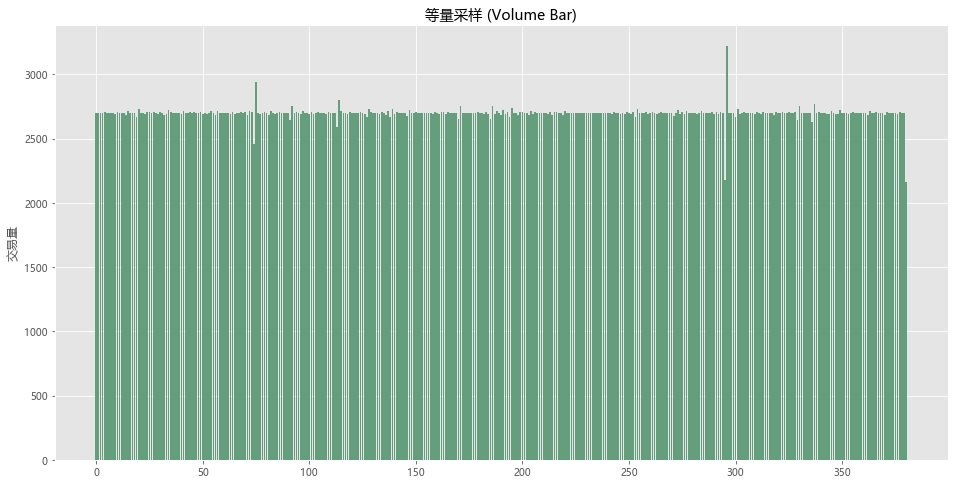

In [ ]:
plt.bar( np.arange(len(volume_group)), volume_group['homeNotional'].sum(), color=g_hex )
plt.title('等量采样 (Volume Bar)')
plt.ylabel('交易量')
plt.show()

再来看看按等量采样下每个 bar 里含有多少个 tick 数据。

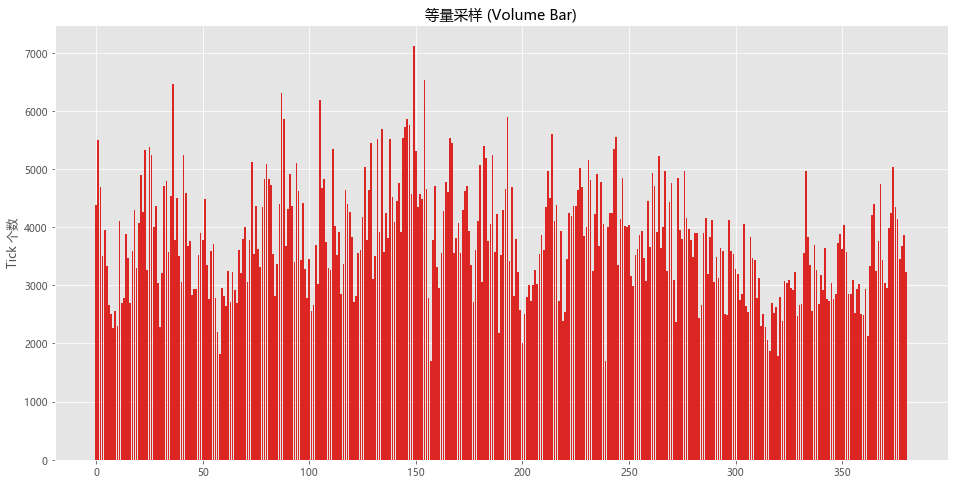

In [ ]:
plt.bar( np.arange(len(volume_group)), volume_group.size().values, color=r_hex )
plt.title('等量采样 (Volume Bar)')
plt.ylabel('Tick 个数')
plt.show()

In [ ]:
print( np.sum(volume_group.size()) )

1434823


In [ ]:
data_volume_vwap = volume_group.apply(vwap, 'price', 'homeNotional')
data_volume_vwap.head(3).append(data_tick_vwap.tail(3))

groupID
0.0      5271.901733
1.0      5268.378268
2.0      5264.330908
385.0    5384.656864
386.0    5376.852452
387.0    5377.549229
dtype: float64

此时我们需要每个 volume bar 对应的时间戳。简单，用每个组的数据个数累加起来得到 `idx`，作为行标签从 `data['timestap]` 获取相对应时间戳，画出 volume bar 的线状图。

In [ ]:
idx = np.cumsum( volume_group.size() ) - 1
t_volume = data['timestamp'][idx].values
vwap_volume = data_volume_vwap.values

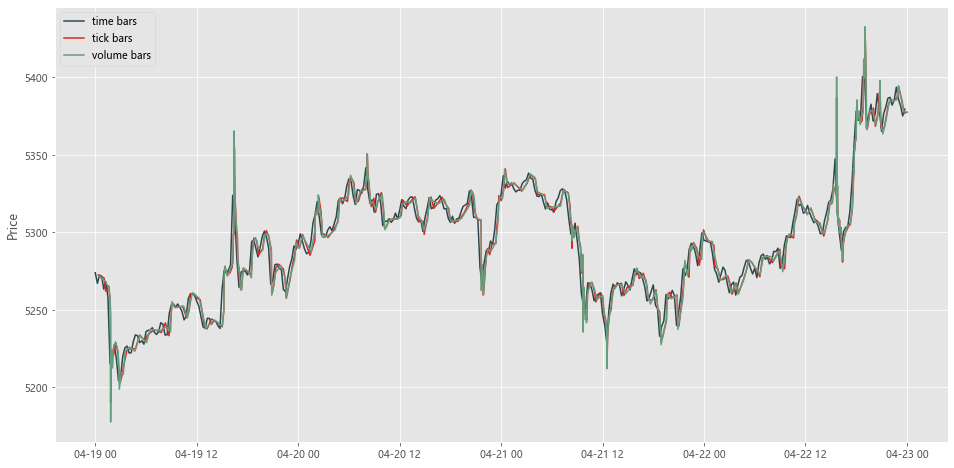

In [ ]:
plt.plot( t_time, vwap_time, color=dt_hex, label='time bars' )
plt.plot( t_tick, vwap_tick, color=r_hex, label='tick bars' )
plt.plot( t_volume, vwap_volume, color=g_hex, label='volume bars' )
plt.legend( loc=0, frameon=True )
plt.ylabel('Price')
plt.show()

等量采样优点：

    一些研究发现按 volume bar 来取样得到的数据比 tick bar 更接近独立正态同分布 (IID)，此外不少关于市场微观理论都是基于价格和成交量来研究的，因此用 volume bar 能更好的结合那些研究。

等量采样缺点：

    不过 volume bar 也有自身的问题，假设迅雷股票在 6 个月内从 6 美元涨了 400% 到 24 美元，一开始你买了 1000 股迅雷花了 6000 美元，那么在终止点卖只需要卖 250 股票 (6000 美元) 就能回本。如果按 volume bar 来看，1000 股到 250 股波动很大，但实际上成交额都是 6000 美元。此外，股票的量在分割 (split) 和反向分割 (reverse split) 都会变化很大，但股票的额并没有变。

如何改进？用**等额采样**方法。

### <font color='#2b4750' face='微软雅黑'>2.5 等额采样之 Dollar Bar</font><a name='2.5'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#2)

等额采样是将 tick 数据转换为 dollar bars，以每段时间含**固定成交额**的前提下中采样得到 (比如固定每 10000 美元)。这里的 dollar 泛指交易产品的计价货币 (denominated currency)，也可以是欧元、英镑、日元或人民币。

这个固定的成交量如何确定呢？和等量采样中的方法一样，先得到 bar 的个数 (4 个)。在等额采样下，我们计算累积成交额再除以 bar 的个数。

    每个 bar 含的成交额 = 总成交额 / bar 数

Dollar bars 的简单示意图如下：

<img src="Dollar Bar.PNG" style="width:600px;height:220px;">

采样 dollar bar 和采样 volume bar 的方法是类似的：

1. 计算总成交额是 13500

2. 计算每个 bar 的成交额是 4500 = 13500/3 

3. 用 4500 作为标准来组成 bar，前 2 个 tick 接起来的成交额为 4000，但 3 个 tick 接起来的成交额为 7000 了，因此第 1-2 个 tick 组成 bar 1，第 3 个 tick 单独组成 bar 2，第 4-5 个 tick 组成 bar 3，第 6 个 tick 单独组成 bar 4

首先用 `cumsum()` 函数计算累积成交额 `'foreignNotional'`，用 `assign()` 函数并储存在 DataFrame 的 `'cumDollar'` 栏下。

In [ ]:
data_cum_dollar = data.assign( cumDollar=data['foreignNotional'].cumsum() )
data_cum_dollar.head(3).append(data_cum_dollar.tail(3))

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional,cumDollar
0,2019-04-19 00:00:08.318873,XBTUSD,Sell,10,5278.0,MinusTick,f62c0ad2-c165-3446-a99e-d081c2e6ea65,189470,0.001895,10.0,1.000000e+01
1,2019-04-19 00:00:08.367122,XBTUSD,Sell,22959,5278.0,ZeroMinusTick,46a184e2-ef8c-aa5e-fb90-81f325174fa5,435004173,4.350042,22959.0,2.296900e+04
2,2019-04-19 00:00:08.449684,XBTUSD,Buy,510,5278.5,PlusTick,ac2befd6-ccc8-9fac-be93-75b686565d07,9661950,0.096620,510.0,2.347900e+04
1434820,2019-04-22 23:59:54.831787,XBTUSD,Sell,14690,5382.5,ZeroMinusTick,7139ea9f-fb14-ee82-3740-d3edf3206685,272925510,2.729255,14690.0,5.446496e+09
1434821,2019-04-22 23:59:59.321668,XBTUSD,Buy,3514,5383.0,PlusTick,f9e494c7-d5ac-453e-737f-e2ca6875d279,65279578,0.652796,3514.0,5.446499e+09
1434822,2019-04-22 23:59:59.321668,XBTUSD,Buy,6486,5383.0,ZeroPlusTick,81439489-8f7e-6cf2-3ab9-e77be2e07f4a,120490422,1.204904,6486.0,5.446506e+09


来看看按等额采样下每个 bar 里含多少成交额。第 1 行计算总成交额 5446505640，第 2-3 行计算每条 bar 含的成交额并弄成整百 14183600 (例如：14183614 就转化成 14183600)。

In [ ]:
total_dollar = data_cum_dollar.cumDollar.values[-1]
dollar_per_bar = total_dollar / num_time_bars
dollar_per_bar  = int(round( dollar_per_bar, -2))

print( '所有数据的总成交额为', total_dollar )
print( '等额采样下 Bar 的个数为', num_time_bars )
print( '每个 Bar 含有的成交额为', dollar_per_bar )

所有数据的总成交额为 5446505640.0
等额采样下 Bar 的个数为 384
每个 Bar 含有的成交额为 14183600


接下来的代码按额 (dollar) 来分组。第 1-2 行用运算符 `//` 对 `df.cumDollar` 进行取整，[0, 11000000, 14000000, 20000000, 21000000, 22000000] // 14183600 就等于 [0, 0, 0, 1, 1, 1]。取整的数被巧妙的当成 `groupID` 用来分组。

从下面的结果来看，在 GroupID 等于 0 的那组里，cumDollar 最后的值是 14180484，非常接近 14183600。

In [ ]:
dollar_group = data_cum_dollar.assign( groupID=lambda df: df.cumDollar // dollar_per_bar ) \
                              .groupby('groupID')
print_groups( dollar_group )

来看看按等额抽样下每个 bar 含额多少，从下图看几乎都是 14000000 左右。

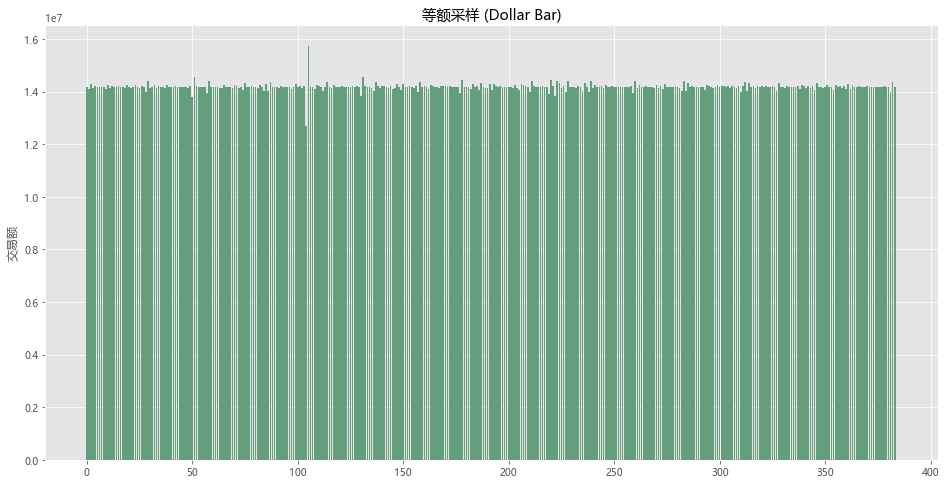

In [ ]:
plt.bar( np.arange(len(dollar_group)), dollar_group['foreignNotional'].sum(), color=g_hex )
plt.title('等额采样 (Dollar Bar)')
plt.ylabel('交易额')
plt.show()

再来看看按等额采样下每个 bar 里含有多少个 tick 数据。

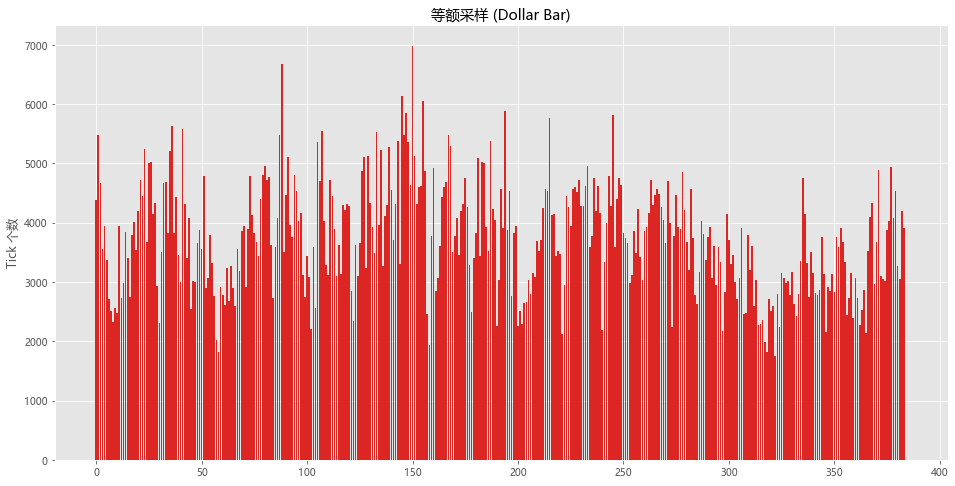

In [ ]:
plt.bar( np.arange(len(dollar_group)), dollar_group.size().values, color=r_hex )
plt.title('等额采样 (Dollar Bar)')
plt.ylabel('Tick 个数')
plt.show()

In [ ]:
print( np.sum(dollar_group.size()) )

1434823


In [ ]:
data_dollar_vwap = dollar_group.apply(vwap, 'price', 'homeNotional')
data_dollar_vwap.head(3).append(data_dollar_vwap.tail(3))

groupID
0.0      5271.922243
1.0      5268.473608
2.0      5264.322310
382.0    5379.185456
383.0    5377.161079
384.0    5383.000000
dtype: float64

In [ ]:
idx = np.cumsum( dollar_group.size() ) - 1
t_dollar = data['timestamp'][idx].values
vwap_dollar = data_dollar_vwap.values

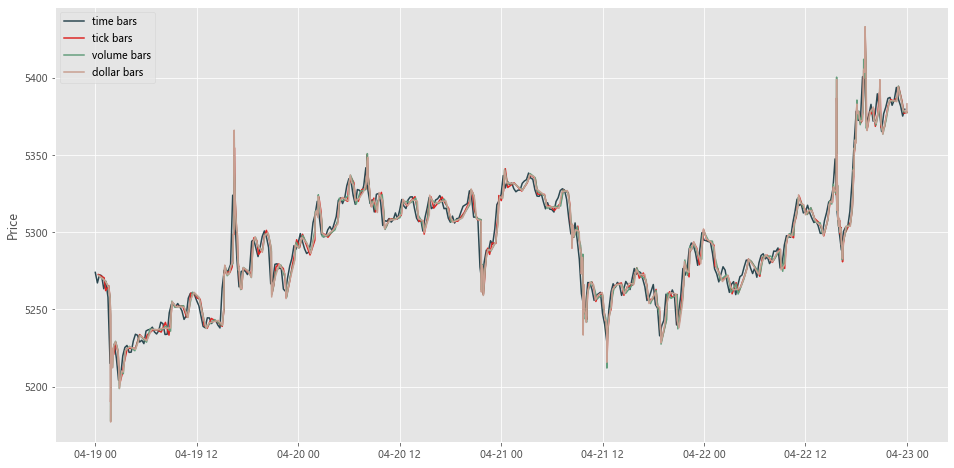

In [ ]:
plt.plot( t_time, vwap_time, color=dt_hex, label='time bars' )
plt.plot( t_tick, vwap_tick, color=r_hex, label='tick bars' )
plt.plot( t_volume, vwap_volume, color=g_hex, label='volume bars' )
plt.plot( t_dollar, vwap_dollar, color=tn_hex, label='dollar bars' )
plt.legend( loc=0, frameon=True )
plt.ylabel('Price')
plt.show()

# <font color='#dc2624' face='微软雅黑'>3. `mlfinlab` 自带函数采样</font><a name='3'></a>
[<font color='black' face='微软雅黑'>回到目录</font>](#toc)

### <font color='#2b4750' face='微软雅黑'>3.1 数据预处理</font><a name='3.1'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

本节使用的标普 500 价值股 ETF (IVE) tick 级别的数据从来自以下链接。

    http://www.kibot.com/free_historical_data.aspx
    
下载 IVE 的数据是从

    2009 年 9 月 28 日早上 9:30

到

    2019 年 7 月 31 日下午 16:00

数据存在 txt 格式，如下图所示 (注意最后三条数据的时间晚于下午 16:00，但是成交量为 0)。

<img src="IVE data.PNG" style="width:300px;height:360px;">

文本 txt 里面的 6 栏数据没有标题栏，我们去上面链接读到这句话。

> We use standard comma-delimited text files. This is the order of the fields in every 1 minute or higher interval file: Date,Time,Open,High,Low,Close,Volume.

那么每一栏代表的意思分别是

    日期、时间、价格、买价、卖价、成交量
    
接下来用 pandas 读取将数据转换成 DataFrame，并做一些处理，用的是下面 IO 函数。

In [ ]:
def IO( in_path, out_path ):
    cols = ['date','time','price','bid','ask','volume']
    
    df = (pd.read_csv( in_path, header=None )
          .rename( columns=dict(zip(range(len(cols)),cols)) )
          .assign( date_time=lambda df: (pd.to_datetime(df['date']+df['time'],
                                                  format='%m/%d/%Y%H:%M:%S')) )
          .drop( ['date','time'], axis=1 )
          .set_index('date_time'))
    
    df.to_parquet( out_path, engine='pyarrow' )

解释一下代码：

- 第 2 行定义好 6 栏数据的名称，'date', 'time', 'price', 'bid', 'ask', 'volume'。
- 第 4 行用 `read_csv()` 函数来从路径为 in_path 的文本读取数据。
- 第 5 行将上面定义好的数据栏名称作为 DataFrame 的 columns。
- 第 6 行将日期 (date) 和时间 (time) 合并，用 `assign()` 函数将合并栏起名为 date_time 栏。从 txt 文本可看出日期的格式是 '%m/%d/%Y'，时间的格式是'%H:%M:%S'。
- 第 8 行用 `drop()` 函数把 `date` 和 `time` 栏删掉，因为已经有 `date_time` 栏了，信息重复了。
- 第 9 行把用 `set_index()` 函数把 date_time 栏作为 index。
- 第 10 行就是用 to_parquet 将数据存成 Parquet 格式，唯一需要注意是要选取 engin 参数为 'pyarrow' 或者 'fastparquet'。

由于 txt 数据太大，储存成 csv 供以后加载速度会慢，因此我们选择将 DataFrame 存储成 Parquet 格式。需要安装 pyarrow 将数据转成 parquet 格式。在 Anaconda 命令框或 Jupyter Notebook 运行 `pip install pyarrow`。 

In [ ]:
in_path = PurePath('IVE_tickbidask.txt');
out_path = PurePath('IVE_tickbidask.parquet');
IO( in_path, out_path )

查看 txt 和 parquet 文件的大小可看出，数据从 300 MB 压缩到 47 MB。

In [ ]:
data = pd.read_parquet( out_path, engine='pyarrow' )
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6927699 entries, 2009-09-28 09:30:00 to 2019-07-31 20:00:00
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   price   float64
 1   bid     float64
 2   ask     float64
 3   volume  int64  
dtypes: float64(3), int64(1)
memory usage: 264.3 MB


让我们看看数据的前 10 行。

In [ ]:
data.head(10)

,price,bid,ask,volume
date_time,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100
2009-09-28 09:30:00,50.71,50.70,50.79,638
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:32,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100
2009-09-28 09:31:33,50.75,50.75,50.76,100


### <font color='#DC2624' face='微软雅黑'>处理重复日期</font>

发现出来什么问题么？有很多重复的数据！要么是 `date_time` 重复了，要么是整行重复了。一开始我以为是操作错误，准备用 `drop_duplicate()` 函数将重复值删去，后来发现有太多类似情况，不可能全是操作错误，后来读到了上面链接中的这句话。

> For each trade, current best bid/ask values are recorded together with the transaction price and volume. Trade records are not aggregated and all transactions are included in their consecutive order.

蓝色高亮部分说的是上面 tick 数据并没有整合，而是一条一条收集的。其实每条数据的时间戳 (timestamp) 不见得刚好精准到秒，有的可能发生在毫秒，比如在 8:30:00:001 和 8:30:00:057 时点上交易的两条数据都被记录成8:30:00 上交易。这样一个 date_time 很可能对应若干条数据。

我们进一步要做的是在每个 date_time 做一些整合 (aggregrate) 操作。

In [ ]:
def print_groups(groupobject):
    for name, group in groupobject:
        print( '\n', name )
        print( group.head(3).append(group.tail(3)) )

用 `groupby()` 在 date_time 分组，在每个不同 date_time 值下得到一个 DataFrame。用数据前十行做分组找规律。

In [ ]:
small_data = data.iloc[:10,:]
group = small_data.groupby(small_data.index)
for name, grp in group:
    print('\n', name)
    print(grp)


 2009-09-28 09:30:00
                     price   bid    ask  volume
date_time                                      
2009-09-28 09:30:00  50.79  50.7  50.79     100
2009-09-28 09:30:00  50.71  50.7  50.79     638

 2009-09-28 09:31:32
                     price    bid    ask  volume
date_time                                       
2009-09-28 09:31:32  50.75  50.75  50.76     100
2009-09-28 09:31:32  50.75  50.75  50.76     100

 2009-09-28 09:31:33
                     price    bid    ask  volume
date_time                                       
2009-09-28 09:31:33  50.75  50.75  50.76     100
2009-09-28 09:31:33  50.75  50.75  50.76     100
2009-09-28 09:31:33  50.75  50.75  50.76     100
2009-09-28 09:31:33  50.75  50.75  50.76     100
2009-09-28 09:31:33  50.75  50.75  50.76     100
2009-09-28 09:31:33  50.75  50.75  50.76     100


下一步就用 `aggregate()` 函数来整合了，关键是以什么样的方式来整合呢？

- price, bid, ask 栏按求平均的方式整合，用 `mean()` 函数
- volume 栏按求和的方式整合，用 `sum()` 函数

以字典的形式来设定 - {栏名称 : 函数名}，比如 `{'price' : 'mean'}`。

In [ ]:
group = data.groupby(data.index)
data = group.aggregate( {'price': 'mean', 
                          'bid': 'mean',
                          'ask': 'mean',
                          'volume': 'sum'} )
data.head(3).append(data.tail(3))

,price,bid,ask,volume
date_time,,,,
2009-09-28 09:30:00,50.75,50.7000,50.7900,738
2009-09-28 09:31:32,50.75,50.7500,50.7600,200
2009-09-28 09:31:33,50.75,50.7425,50.7575,800
2019-07-31 16:10:00,118.61,117.2000,119.1900,0
2019-07-31 18:30:00,118.61,117.4200,120.1500,0
2019-07-31 20:00:00,118.61,117.4200,120.1500,0


### <font color='#DC2624' face='微软雅黑'>处理异常值</font>
看看数据里有没有什么异常值 (outlier)，用 **`seaborn`** 里面的 `boxplot()` 函数。

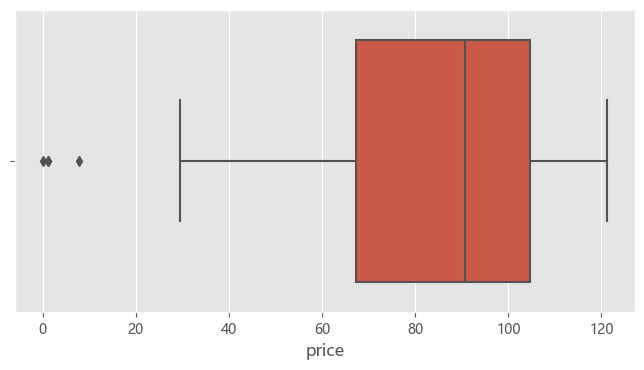

In [ ]:
fig = plt.figure( figsize=(8,4), dpi=100 )
sns.boxplot(data.price)
plt.show()

从上图最左边几个点的值 IVE 的价格有几个在 0-10 之间，显然是错误记录。我们用 median absolute deviation (MAD) 的方法来确定异常值，公式如下：

<br>
<font color='blue'>
\begin{equation}
M_i = \frac{0.6745\times(x_i - \bar{x})}{MAD}
\end{equation}
</font>

其中
- $\bar{x}$ 是 $x$ 的中位数
- $MAD$ 是 $x_i - \bar{x}$ 的中位数
- $0.6745$ 是正态分布的 75 分位值

下面代码就把上面公式实现一遍，算出分数 score 和阈值 threshold 比，当 score > threshold 时认定有异常值。

In [ ]:
def mad_outlier( y, threshold=3. ):
    '''
    compute outliers based on median absolute deviation (MAD)
    # INPUT
        y: numpy array
        threshold: float
    # OUTPUT
        index of outliers: bool
    '''
    median = np.median(y)
    diff = np.abs(y - median)
    MAD = np.median(diff)

    score = 0.6745 * diff / MAD

    return score > threshold

找出异常值的索引 idx 并看有几个。

In [ ]:
idx = mad_outlier( data.price.values )
data.loc[idx]

,price,bid,ask,volume
date_time,,,,
2010-05-06 14:49:07,0.110000,0.10,44.030000,500
2010-05-06 14:53:30,1.100000,1.10,30.280000,2600
2010-05-06 14:53:32,1.100000,1.10,30.280000,2600
2010-05-06 14:55:32,7.762857,2.48,50.532857,5000


在百万条数据中只有 4 个，可直接删除。首先看看不带异常数据的 boxplot，一切正常。

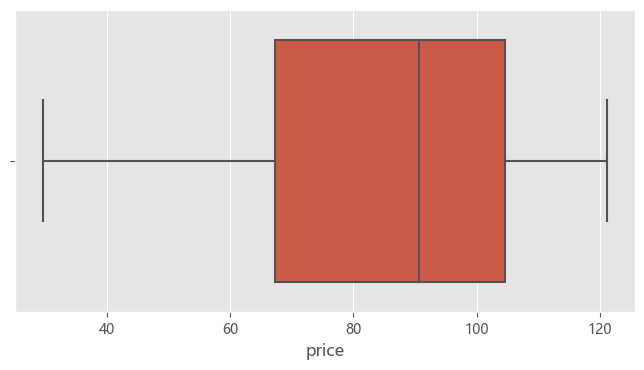

In [ ]:
fig = plt.figure( figsize=(8,4), dpi=100 )
sns.boxplot( data.loc[~idx].price )
plt.show()

可以大胆的删除这 4 条异常数据。

In [ ]:
data = data.loc[~idx]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2784797 entries, 2009-09-28 09:30:00 to 2019-07-31 20:00:00
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   price   float64
 1   bid     float64
 2   ask     float64
 3   volume  int64  
dtypes: float64(3), int64(1)
memory usage: 106.2 MB


最后还发现有些数据的成交量为零，也将其删除。

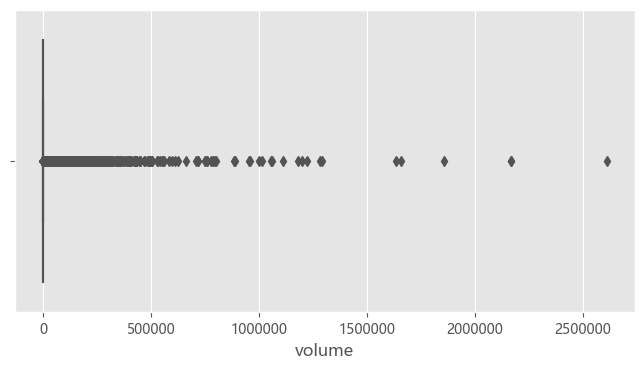

In [ ]:
fig = plt.figure( figsize=(8,4), dpi=100 ) 
sns.boxplot(data.volume)
plt.show()

In [ ]:
data = data.loc[data.volume != 0]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2782620 entries, 2009-09-28 09:30:00 to 2019-07-31 16:00:00
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   price   float64
 1   bid     float64
 2   ask     float64
 3   volume  int64  
dtypes: float64(3), int64(1)
memory usage: 106.1 MB


经过整合重复的 date_time 和删除 price 和 volume 的异常值后，6927699 条数据减少到 2782620 条，现在数据已经是干净的了。

### <font color='#2b4750' face='微软雅黑'>3.2 `mlfinlab` 工具包</font><a name='3.2'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

我们拿 2019 年 7 月 30 日的数据举例。

In [ ]:
s_date='2019-07-30 8:00:00'
e_date='2019-07-30 17:00:00'

df = data.loc[s_date:e_date, ['price','volume']]
df.head(3).append(df.tail(3))

,price,volume
date_time,,
2019-07-30 09:30:00,119.1500,3550
2019-07-30 09:30:26,119.1150,885
2019-07-30 09:32:21,119.0366,334
2019-07-30 15:59:54,119.6100,1938
2019-07-30 15:59:55,119.6100,400
2019-07-30 16:00:00,119.6100,1154


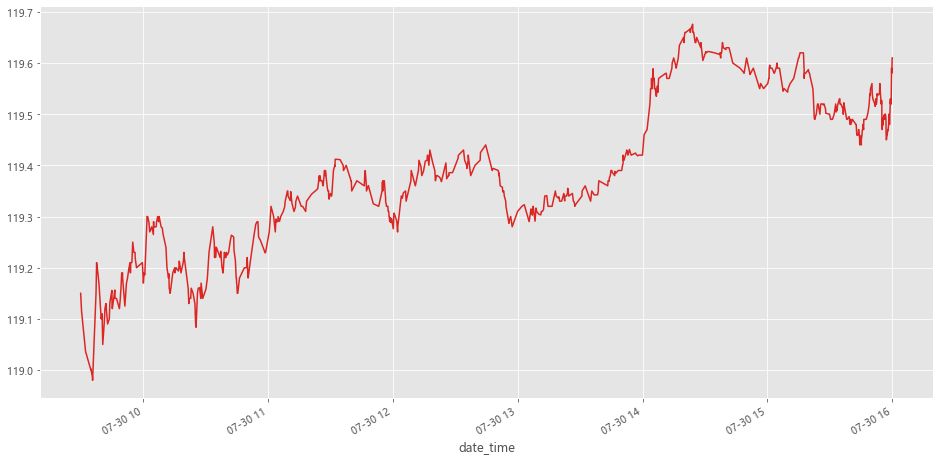

In [ ]:
df.price.plot( color=r_hex );

### <font color='#DC2624' face='微软雅黑'>整合自己实现的函数</font>

将上一节零散的代码整合成函数，便于重复使用，实现的函数包含：

    get_time_bar(data, freq) - 等时采样
    get_tick_bar(data, freq) - 等笔采样
    get_volume_bar(data, freq) - 等量采样
    get_dollar_bar(data, freq) - 等额采样

首先回顾用于计算 VWAP 的 `vwap()` 函数。

In [ ]:
def vwap( group, avg_column, weight_column ):
    p = group[avg_column]
    v = group[weight_column]
    return (p*v).sum() / v.sum()

In [ ]:
def get_time_bar( data, freq ):
    time_group = data.groupby( pd.Grouper(freq=freq) )
    data_bar = time_group.apply( vwap, 'price', 'volume' )
    return data_bar.dropna(), time_group

In [ ]:
freq = '300s'
data_by_time, time_group = get_time_bar( df, freq )
data_by_time

date_time
2019-07-30 09:30:00    119.120415
2019-07-30 09:35:00    119.099842
2019-07-30 09:40:00    119.123453
2019-07-30 09:45:00    119.149328
2019-07-30 09:50:00    119.189771
                          ...    
2019-07-30 15:40:00    119.458897
2019-07-30 15:45:00    119.505021
2019-07-30 15:50:00    119.542020
2019-07-30 15:55:00    119.541444
2019-07-30 16:00:00    119.610000
Length: 79, dtype: float64

In [ ]:
def get_tick_bar( data, freq ):
    time_group = data.groupby( pd.Grouper(freq=freq) )
    num_time_bars = len(time_group)
    
    total_ticks = len(data)
    num_ticks_per_bar = total_ticks / num_time_bars
    num_ticks_per_bar = np.ceil(num_ticks_per_bar)
        
    tick_group = data.assign( groupID=lambda df: np.arange(len(df)) // num_ticks_per_bar ) \
                 .groupby('groupID')
    data_bar = tick_group.apply( vwap, 'price', 'volume' )
    
    idx = np.cumsum( tick_group.size() ) - 1
    data_bar.index = data.index[idx]
    
    return data_bar.dropna(), tick_group

In [ ]:
data_by_tick, volume_group = get_tick_bar( df, freq )
data_by_tick

date_time
2019-07-30 09:38:14    119.115701
2019-07-30 09:42:08    119.106347
2019-07-30 09:46:48    119.131209
2019-07-30 09:51:15    119.149405
2019-07-30 09:54:43    119.201409
                          ...    
2019-07-30 15:58:14    119.467831
2019-07-30 15:59:00    119.496783
2019-07-30 15:59:33    119.535556
2019-07-30 15:59:45    119.581433
2019-07-30 16:00:00    119.600252
Length: 79, dtype: float64

In [ ]:
def get_volume_bar( data, freq ):
    time_group = data.groupby( pd.Grouper(freq=freq) )
    num_time_bars = len(time_group)
    
    data_cum_volume = data.assign( cumVolume=data['volume'].cumsum() )
    total_volume = data_cum_volume.cumVolume.values[-1]
    volume_per_bar = total_volume / num_time_bars
    volume_per_bar  = int(round( volume_per_bar, -2))
        
    volume_group = data_cum_volume.assign( groupID=lambda df: df.cumVolume // volume_per_bar ) \
                              .groupby('groupID')
    data_bar = volume_group.apply( vwap, 'price', 'volume' )
    
    idx = np.cumsum( volume_group.size() ) - 1
    data_bar.index = data.index[idx]
    
    return data_bar.dropna(), volume_group

In [ ]:
data_by_volume, volume_group = get_volume_bar( df, freq )
data_by_volume

date_time
2019-07-30 09:34:52    119.131314
2019-07-30 09:42:57    119.088414
2019-07-30 09:43:46    119.100000
2019-07-30 09:49:43    119.136678
2019-07-30 09:55:02    119.193262
                          ...    
2019-07-30 15:59:38    119.581218
2019-07-30 15:59:42    119.586110
2019-07-30 15:59:51    119.590000
2019-07-30 15:59:52    119.596923
2019-07-30 16:00:00    119.610000
Length: 61, dtype: float64

In [ ]:
def get_dollar_bar( data, freq ):
    time_group = data.groupby( pd.Grouper(freq=freq) )
    num_time_bars = len(time_group)
    
    data_cum_dollar = data.assign( cumDollar=(data['volume']*data['price']).cumsum() )
    total_dollar = data_cum_dollar.cumDollar.values[-1]
    dollar_per_bar = total_dollar / num_time_bars
    dollar_per_bar  = int(round( dollar_per_bar, -2))
        
    dollar_group = data_cum_dollar.assign( groupID=lambda df: df.cumDollar // dollar_per_bar ) \
                              .groupby('groupID')
    data_bar = dollar_group.apply( vwap, 'price', 'volume' )
    
    idx = np.cumsum( dollar_group.size() ) - 1
    data_bar.index = data.index[idx]
    
    return data_bar.dropna(), dollar_group

In [ ]:
data_by_dollar, dollar_group = get_dollar_bar( df, freq )
data_by_dollar

date_time
2019-07-30 09:34:52    119.131314
2019-07-30 09:42:57    119.088414
2019-07-30 09:43:46    119.100000
2019-07-30 09:49:19    119.136323
2019-07-30 09:54:43    119.189776
                          ...    
2019-07-30 15:59:38    119.590000
2019-07-30 15:59:43    119.587592
2019-07-30 15:59:51    119.590000
2019-07-30 15:59:55    119.601203
2019-07-30 16:00:00    119.610000
Length: 61, dtype: float64

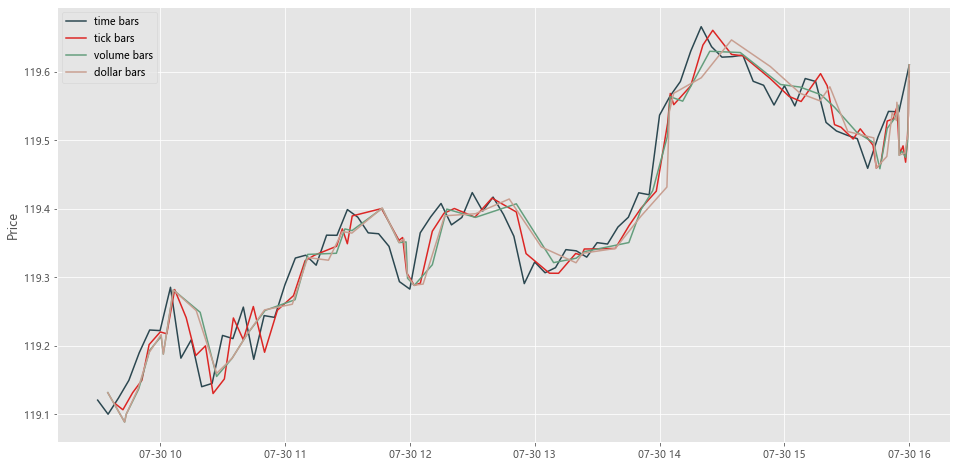

In [ ]:
plt.figure( figsize=(16,8), dpi=72 )
plt.plot( data_by_time.index, data_by_time.values, color=dt_hex, label='time bars' )
plt.plot( data_by_tick.index, data_by_tick.values, color=r_hex, label='tick bars' )
plt.plot( data_by_volume.index, data_by_volume.values, color=g_hex, label='volume bars' )
plt.plot( data_by_dollar.index, data_by_dollar.values, color=tn_hex, label='dollar bars' )
plt.legend( loc=0, frameon=True )
plt.ylabel('Price')
plt.show()

### <font color='#DC2624' face='微软雅黑'>对比 `mlfinlab` 和自己实现的函数</font>

In [ ]:
freq = '60s'
time_group = df.groupby( pd.Grouper(freq=freq) )
num_time_bars = len(time_group)
total_dollar = np.sum(df['price']*df['volume'])
dollar_per_bar = total_dollar / num_time_bars
dollar_per_bar  = int(round( dollar_per_bar, -2))

print( '所有数据的总成交额为', total_dollar )
print( '等额采样下 Bar 的个数为', num_time_bars )
print( '每个 Bar 含有的成交额为', dollar_per_bar )

所有数据的总成交额为 47727823.56948571
等额采样下 Bar 的个数为 391
每个 Bar 含有的成交额为 122100


接着我们使用 `mlfinlab` 里面的内置函数 `get_dollar_bars()` 来做等交易额采样。

从文档介绍可知 (https://mlfinlab.readthedocs.io/en/latest/)，

    get_dollar_bars( file_path_or_df: Union[str, Iterable[str], pandas.core.frame.DataFrame], 
                     threshold: Union[float, pandas.core.series.Series] = 70000000,
                     batch_size: int = 20000000,
                     verbose: bool = True,
                     to_csv: bool = False,
                     output_path: Optional[str] = None)


经过研究发现函数读取的 DataFrame 需要重设行标签，因此第一个参数设置为 `file_path_or_df = df.reset_index()`，第二个参数 `threshold` 设置为之前计算的 `dollar_per_bar`。

In [ ]:
print('Creating Dollar Bars')
dollar = ml.data_structures.get_dollar_bars( df.reset_index(), 
                                             threshold=dollar_per_bar )

Creating Dollar Bars
Reading data in batches:
Batch number: 0
Returning bars 



对于每一个组，`get_dollar_bar()` 函数的产出为时间、笔数、OHLC (和自己实现产出 VWAP 不一样)、交易量等。

In [ ]:
dollar.head(3).append(dollar.tail(3))

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2019-07-30 09:30:00,1,119.150000,119.150000,119.150000,119.150000,3550,0,1,422982.500000
1,2019-07-30 09:32:21,3,119.115000,119.115000,119.036600,119.036600,1219,0,2,145174.999400
2,2019-07-30 09:37:23,8,119.000600,119.150000,118.980000,119.150000,1079,554,5,128411.041800
178,2019-07-30 15:59:52,783,119.596923,119.596923,119.596923,119.596923,4806,4806,1,574782.812308
179,2019-07-30 15:59:54,784,119.610000,119.610000,119.610000,119.610000,1938,1938,1,231804.180000
180,2019-07-30 16:00:00,786,119.610000,119.610000,119.610000,119.610000,1554,1554,2,185873.940000


对比自己实现的 `mlfinlab` 实现 dollar bar 的折现图，差别不大。

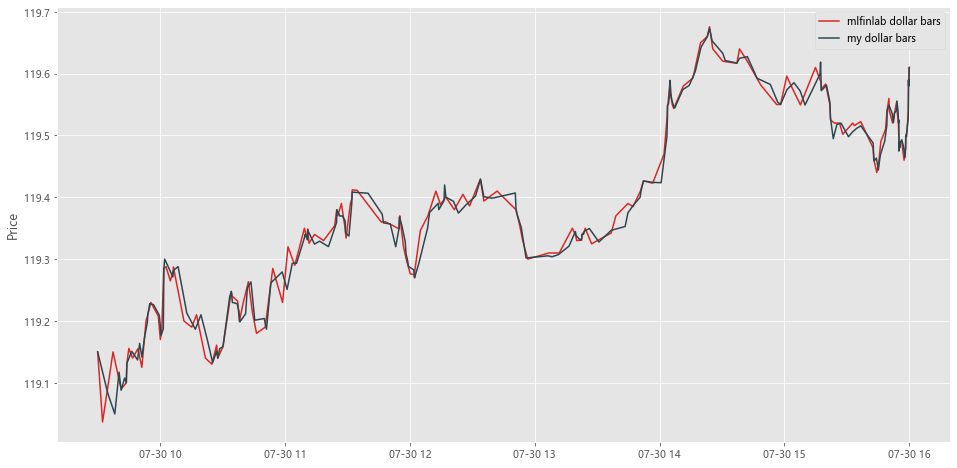

In [ ]:
data_by_dollar, dollar_group = get_dollar_bar( df, freq )

plt.figure( figsize=(16,8), dpi=72 ) 
plt.plot( dollar['date_time'], dollar['close'], color=r_hex, label='mlfinlab dollar bars' )
plt.plot( data_by_dollar.index, data_by_dollar.values, color=dt_hex, label='my dollar bars' )
plt.legend( loc=0, frameon=True )
plt.ylabel('Price')
plt.show()

在 **`mlfinlab`** 中， 除了等额采样的 `get_dollar_bars()` 函数，其他三个等时、等比和等量采样的对应的 `get_time_bars()`, `get_tick_bars()` 和 `get_volume_bars()` 函数详情如下：

    get_time_bars( file_path_or_df: Union[str, Iterable[str], pandas.core.frame.DataFrame],
                   resolution: str = 'D',
                   num_units: int = 1,
                   batch_size: int = 20000000,
                   verbose: bool = True,
                   to_csv: bool = False,
                   output_path: Optional[str] = None )
                   
    get_tick_bars( file_path_or_df: Union[str, Iterable[str], pandas.core.frame.DataFrame],
                   threshold: Union[float, pandas.core.series.Series] = 70000000,
                   batch_size: int = 20000000,
                   verbose: bool = True,
                   to_csv: bool = False,
                   output_path: Optional[str] = None)
                   
    get_volume_bars( file_path_or_df: Union[str, Iterable[str], pandas.core.frame.DataFrame],
                     threshold: Union[float, pandas.core.series.Series] = 70000000,
                     batch_size: int = 20000000,
                     verbose: bool = True,
                     to_csv: bool = False,
                     output_path: Optional[str] = None)

In [ ]:
print('Creating Time Bars')
time = ml.data_structures.get_time_bars( df.reset_index(), 
                                         resolution='MIN', 
                                         num_units=1 )
num_time_bars = len(time)

Creating Time Bars
Reading data in batches:
Batch number: 0
Returning bars 



In [ ]:
time.head(3).append(time.tail(3))

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,1564479060,3,119.150000,119.150000,119.1150,119.1150,4435,0,2,5.283993e+05
1,1564479180,4,119.036600,119.036600,119.0366,119.0366,334,0,1,3.975822e+04
2,1564479300,6,119.000600,119.002200,119.0006,119.0022,609,454,2,7.247209e+04
298,1564502280,749,119.476667,119.476667,119.4500,119.4683,1483,600,9,1.771674e+05
299,1564502340,760,119.480000,119.520000,119.4800,119.5200,7399,6899,11,8.841460e+05
300,1564502400,786,119.520000,119.610000,119.5200,119.6100,32263,28763,26,3.858049e+06


In [ ]:
total_ticks = len(df)
num_ticks_per_bar = total_ticks / num_time_bars
num_ticks_per_bar = np.ceil(num_ticks_per_bar)

print('Creating Tick Bars')
tick = ml.data_structures.get_tick_bars( df.reset_index(), 
                                         threshold=num_ticks_per_bar )

Creating Tick Bars
Reading data in batches:
Batch number: 0
Returning bars 



In [ ]:
tick.head(3).append(tick.tail(3))

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2019-07-30 09:32:21,3,119.1500,119.150000,119.0366,119.036600,4769,0,3,568157.499400
1,2019-07-30 09:35:43,6,119.0006,119.002200,118.9850,118.985000,879,454,3,104598.041800
2,2019-07-30 09:37:40,9,118.9800,119.210000,118.9800,119.210000,300,200,3,35734.000000
259,2019-07-30 15:59:45,780,119.5800,119.590000,119.5800,119.590000,4932,4932,3,589799.780000
260,2019-07-30 15:59:52,783,119.5900,119.596923,119.5900,119.596923,6566,6566,3,785261.212308
261,2019-07-30 16:00:00,786,119.6100,119.610000,119.6100,119.610000,3492,3492,3,417678.120000


In [ ]:
total_volume = df['volume'].sum()
volume_per_bar = total_volume / num_time_bars
volume_per_bar  = int(round( volume_per_bar, -2))

print('Creating Volume Bars')
volume = ml.data_structures.get_volume_bars( df.reset_index(), 
                                             threshold=volume_per_bar )

Creating Volume Bars
Reading data in batches:
Batch number: 0
Returning bars 



In [ ]:
volume.head(3).append(volume.tail(3))

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2019-07-30 09:30:00,1,119.150000,119.150000,119.150000,119.150000,3550,0,1,422982.500000
1,2019-07-30 09:34:52,4,119.115000,119.115000,119.000600,119.000600,1374,0,3,163620.092400
2,2019-07-30 09:38:47,11,119.002200,119.210000,118.980000,119.170000,1365,654,7,162526.908000
150,2019-07-30 15:59:52,783,119.596923,119.596923,119.596923,119.596923,4806,4806,1,574782.812308
151,2019-07-30 15:59:54,784,119.610000,119.610000,119.610000,119.610000,1938,1938,1,231804.180000
152,2019-07-30 16:00:00,786,119.610000,119.610000,119.610000,119.610000,1554,1554,2,185873.940000


In [ ]:
total_dollar = (df['price']*df['volume']).sum()
dollar_per_bar = total_dollar / num_time_bars
dollar_per_bar  = int(round( dollar_per_bar, -2))

print('Creating Dollar Bars')
dollar = ml.data_structures.get_dollar_bars( df.reset_index(), 
                                             threshold=dollar_per_bar )

Creating Dollar Bars
Reading data in batches:
Batch number: 0
Returning bars 



In [ ]:
dollar.head(3).append(dollar.tail(3))

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2019-07-30 09:30:00,1,119.150000,119.150000,119.150000,119.150000,3550,0,1,422982.500000
1,2019-07-30 09:34:52,4,119.115000,119.115000,119.000600,119.000600,1374,0,3,163620.092400
2,2019-07-30 09:38:47,11,119.002200,119.210000,118.980000,119.170000,1365,654,7,162526.908000
146,2019-07-30 15:59:52,783,119.596923,119.596923,119.596923,119.596923,4806,4806,1,574782.812308
147,2019-07-30 15:59:54,784,119.610000,119.610000,119.610000,119.610000,1938,1938,1,231804.180000
148,2019-07-30 16:00:00,786,119.610000,119.610000,119.610000,119.610000,1554,1554,2,185873.940000


### <font color='#2b4750' face='微软雅黑'>3.3 评估采样</font><a name='3.3'></a>
[<font color='black' face='微软雅黑'>回到章首</font>](#3)

采用一年的数据，等时采样是按小时 (1H) 频率进行的。

In [ ]:
s_date='2018-07-30 8:00:00'
e_date='2019-07-30 17:00:00'

df = data.loc[s_date:e_date, ['price','volume']]
df.head(3).append(df.tail(3))

,price,volume
date_time,,
2018-07-30 09:30:00,114.0600,3689
2018-07-30 09:31:04,114.1699,136
2018-07-30 09:31:19,114.1900,100
2019-07-30 15:59:54,119.6100,1938
2019-07-30 15:59:55,119.6100,400
2019-07-30 16:00:00,119.6100,1154


In [ ]:
time = ml.data_structures.get_time_bars( df.reset_index(), 
                                         resolution='H', 
                                         num_units=1 )
num_time_bars = len(time)

Reading data in batches:
Batch number: 0
Returning bars 



In [ ]:
total_ticks = len(df)
num_ticks_per_bar = total_ticks / num_time_bars
num_ticks_per_bar = np.ceil(num_ticks_per_bar)

print('Creating Tick Bars')
tick = ml.data_structures.get_tick_bars( df.reset_index(), 
                                         threshold=num_ticks_per_bar )

Creating Tick Bars
Reading data in batches:
Batch number: 0
Returning bars 



In [ ]:
total_volume = df['volume'].sum()
volume_per_bar = total_volume / num_time_bars
volume_per_bar  = int(round( volume_per_bar, -2))

print('Creating Volume Bars')
volume = ml.data_structures.get_volume_bars( df.reset_index(), 
                                             threshold=volume_per_bar )

Creating Volume Bars
Reading data in batches:
Batch number: 0
Returning bars 



In [ ]:
total_dollar = (df['price']*df['volume']).sum()
dollar_per_bar = total_dollar / num_time_bars
dollar_per_bar  = int(round( dollar_per_bar, -2))

print('Creating Dollar Bars')
dollar = ml.data_structures.get_dollar_bars( df.reset_index(), 
                                             threshold=dollar_per_bar )

Creating Dollar Bars
Reading data in batches:
Batch number: 0
Returning bars 



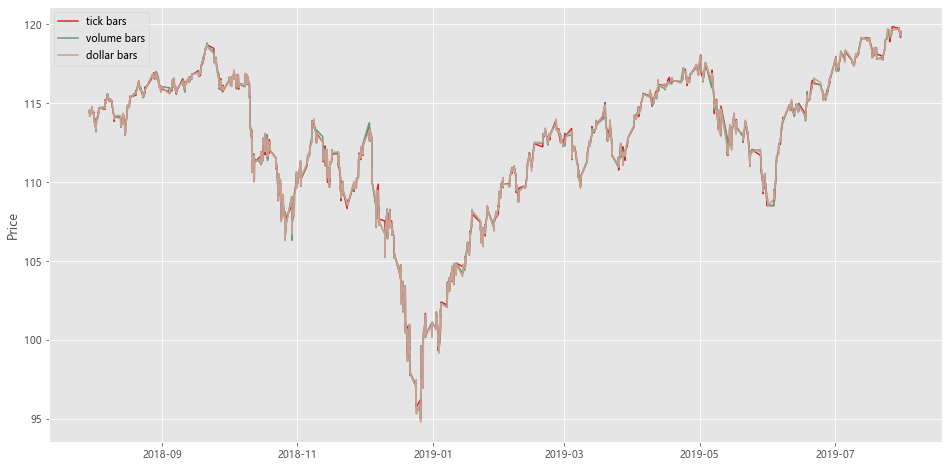

In [ ]:
plt.figure( figsize=(16,8), dpi=72 )
#plt.plot( time['date_time'], time['close'], color=dt_hex, label='time bars' )
plt.plot( tick['date_time'], tick['close'], color=r_hex, label='tick bars' )
plt.plot( volume['date_time'], volume['close'], color=g_hex, label='volume bars' )
plt.plot( dollar['date_time'], dollar['close'], color=tn_hex, label='dollar bars' )
plt.legend( loc=0, frameon=True )
plt.ylabel('Price')
plt.show()

计算采样后价格的收益率。

In [ ]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr))

In [ ]:
time_returns = returns(time['close'])
tick_returns = returns(tick['close'])
volume_returns = returns(volume['close'])
dollar_returns = returns(dollar['close'])

### <font color='#DC2624' face='微软雅黑'>自相关 (auto-correlation)</font>

In [ ]:
bar_types = ['Time Bar', 'Tick Bar', 'Volume Bar', 'Dollar Bar']
bar_returns = [time_returns, tick_returns, volume_returns, dollar_returns]

In [ ]:
def plot_autocorr(bar_types, bar_returns):
    f, axes = plt.subplots(len(bar_types))

    for i, (bar, typ) in enumerate(zip(bar_returns, bar_types)):
        sm.graphics.tsa.plot_acf( bar, lags=20, ax=axes[i],
                                  alpha=0.05, unbiased=True, fft=True,
                                  zero=False,
                                  title=f'{typ} AutoCorr')
    plt.tight_layout()

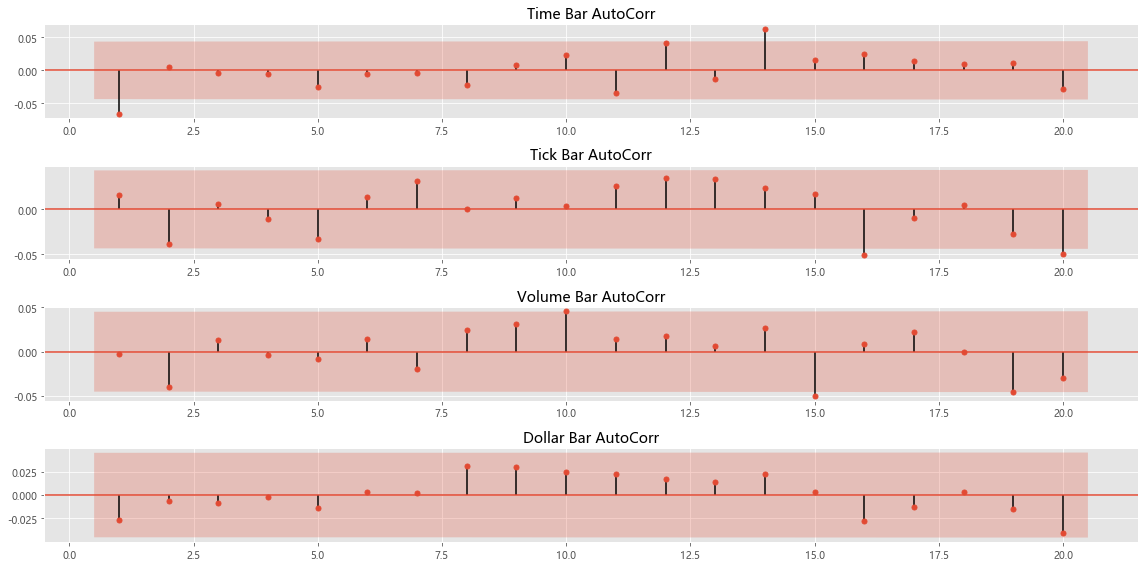

In [ ]:
plot_autocorr(bar_types, bar_returns)

In [ ]:
def get_test_stats( bar_types, bar_returns, test_func, *args, **kwds ):
    
    dct = { bar : ( int(bar_ret.shape[0]), test_func(bar_ret, *args, **kwds) ) 
            for bar, bar_ret in zip(bar_types, bar_returns) }
    df = ( pd.DataFrame.from_dict(dct)
             .rename(index={0:'sample_size', 1:f'{test_func.__name__}_stat'}).T)
    return df

In [ ]:
autocorrs = get_test_stats( bar_types, bar_returns, pd.Series.autocorr )
autocorrs.sort_values('autocorr_stat')

,sample_size,autocorr_stat
Time Bar,2042.0,-0.065358
Dollar Bar,1892.0,-0.026586
Volume Bar,1892.0,-0.002714
Tick Bar,2034.0,0.016552


### <font color='#DC2624' face='微软雅黑'>正态性 (normality)</font>

In [ ]:
def Z_score( s ):
    return (s - s.mean()) / s.std()

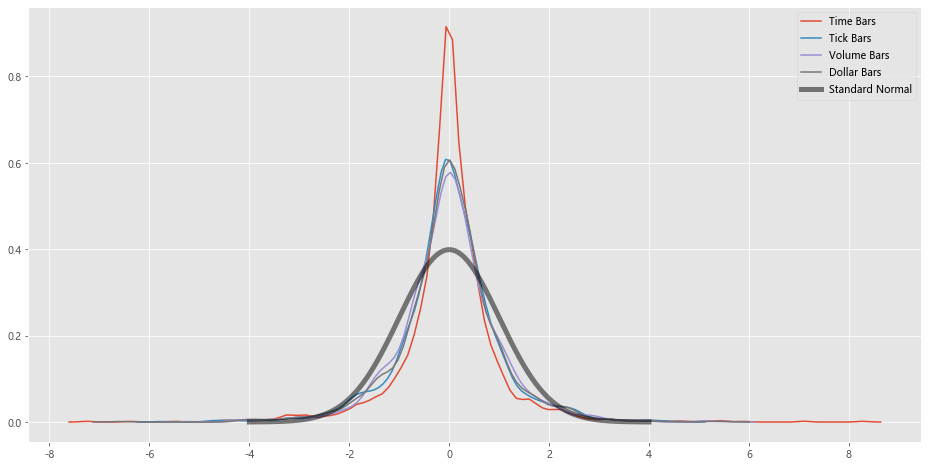

In [ ]:
sns.distplot( Z_score(time_returns), hist=False, label='Time Bars' )
sns.distplot( Z_score(tick_returns), hist=False, label='Tick Bars' )
sns.distplot( Z_score(volume_returns), hist=False, label='Volume Bars' )
sns.distplot( Z_score(dollar_returns), hist=False, label='Dollar Bars' )

x = np.arange(-4, +4, 0.001)                                                   
y = stats.norm.pdf(x) 
plt.plot(x, y, 'k', lw=5, alpha=0.5, label='Standard Normal')

plt.legend();

等时采样 (time bars) 的收益率分布最尖峰肥尾，而等量采样 (volume bars) 的收益率分布最接近正态分布。